# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [18]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
np.random.seed(123) 
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [19]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [20]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [21]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [22]:
#Sample some columns to check the composition of data 
print(azdias['PLZ8_HHZ'].unique())
print(azdias['PLZ8_BAUMAX'].unique())
print(azdias['CJT_GESAMTTYP'].unique())
print(azdias['ARBEIT'].unique())
print(azdias['CAMEO_DEU_2015'].unique())

azdias.isnull().sum().to_frame(name = 'missing_count').head(30)

[ nan   5.   4.   3.   2.   1.]
[ nan   1.   2.   4.   5.   3.]
[  2.   5.   3.   4.   1.   6.  nan]
[ nan   3.   2.   4.   1.   5.   9.]
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']


missing_count
AGER_TYP                           0
ALTERSKATEGORIE_GROB               0
ANREDE_KZ                          0
CJT_GESAMTTYP                   4854
FINANZ_MINIMALIST                  0
FINANZ_SPARER                      0
FINANZ_VORSORGER                   0
FINANZ_ANLEGER                     0
FINANZ_UNAUFFAELLIGER              0
FINANZ_HAUSBAUER                   0
FINANZTYP                          0
GEBURTSJAHR                        0
GFK_URLAUBERTYP                 4854
GREEN_AVANTGARDE                   0
HEALTH_TYP                         0
LP_LEBENSPHASE_FEIN             4854
LP_LEBENSPHASE_GROB             4854
LP_FAMILIE_FEIN                 4854
LP_FAMILIE_GROB                 4854
LP_STATUS_FEIN                  4854
LP_STATUS_GROB                  4854
NATIONALITAET_KZ                   0
PRAEGENDE_JUGENDJAHRE              0
RETOURTYP_BK_S                  4854
SEMIO_SOZ                          0
SEMIO_FAM                          0
SEMIO_REL                          0
SEMIO_MAT                          0
SEMIO_VERT                         0
SEMIO_LUST                         0

From the column sampling, we can tell that besides assigned missing values in the data dictionary, a column can still contain nan. In addition, not all missing values in data dictionary exist in a column.

In [23]:
columns = azdias.columns
columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [24]:
# Identify missing or unknown data values and convert them to NaNs.

def convert_missing(df):
    '''
    Change the values that represent missing values in data dictionary to nan
    '''
    for col in columns: 

        missing = feat_info[feat_info['attribute'] == col]['missing_or_unknown']
        
        #change the panda series into a string
        missing_str = missing.to_string(index = False).strip('[]')

        if missing_str != '':
            #change the string into a list
            missing_list =[x if x in ['X','XX'] else int(x) for x in missing_str.split(',')]
            
            #replace missing values in missing_list with nan 
            df[col] = df[col].replace(missing_list, np.nan)
    return df

    
azdias = convert_missing(azdias)

In [25]:
#verification of the function convert_missing 
print(azdias['ARBEIT'].unique())
print(azdias['CAMEO_DEU_2015'].unique())

[ nan   3.   2.   4.   1.   5.]
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [26]:
# Perform an assessment of how much missing data there is in each column of the data
missing = azdias.isnull().sum().to_frame(name = 'missing_count')
missing['missing_per'] = missing['missing_count']/len(azdias.index)
missing.head(20)

missing_count  missing_per
AGER_TYP                      685843     0.769554
ALTERSKATEGORIE_GROB            2881     0.003233
ANREDE_KZ                          0     0.000000
CJT_GESAMTTYP                   4854     0.005446
FINANZ_MINIMALIST                  0     0.000000
FINANZ_SPARER                      0     0.000000
FINANZ_VORSORGER                   0     0.000000
FINANZ_ANLEGER                     0     0.000000
FINANZ_UNAUFFAELLIGER              0     0.000000
FINANZ_HAUSBAUER                   0     0.000000
FINANZTYP                          0     0.000000
GEBURTSJAHR                   392318     0.440203
GFK_URLAUBERTYP                 4854     0.005446
GREEN_AVANTGARDE                   0     0.000000
HEALTH_TYP                    111196     0.124768
LP_LEBENSPHASE_FEIN            97632     0.109549
LP_LEBENSPHASE_GROB            94572     0.106115
LP_FAMILIE_FEIN                77792     0.087287
LP_FAMILIE_GROB                77792     0.087287
LP_STATUS_FEIN                  4854     0.005446

In [27]:
missing[missing['missing_count'] >0].count()

missing_count    61
missing_per      61
dtype: int64

Here, we see that there are 61 columns contain missing data.

Text(0,0.5,'Frequency')

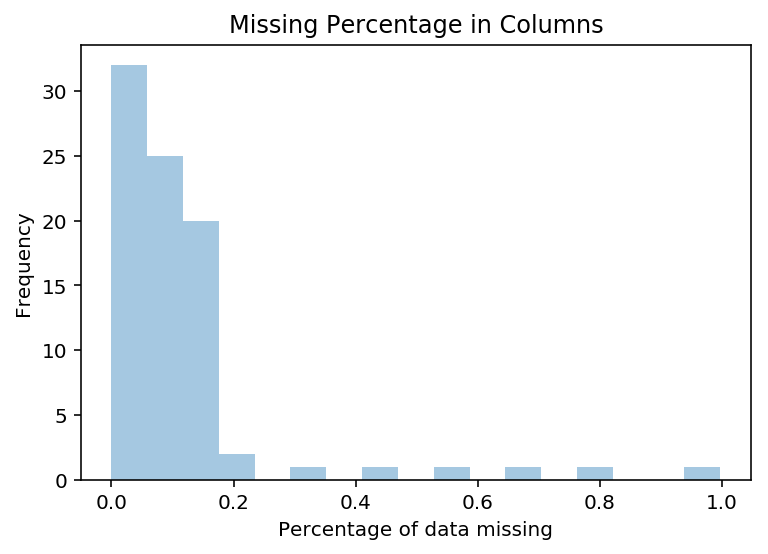

In [28]:
# Investigate patterns in the amount of missing data in each column.
sns.distplot(missing['missing_per'], kde = False)
plt.title('Missing Percentage in Columns', fontsize=12)
plt.xlabel('Percentage of data missing', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

We see that some columns have > 80% of data missing. We want to exclude those columns. 

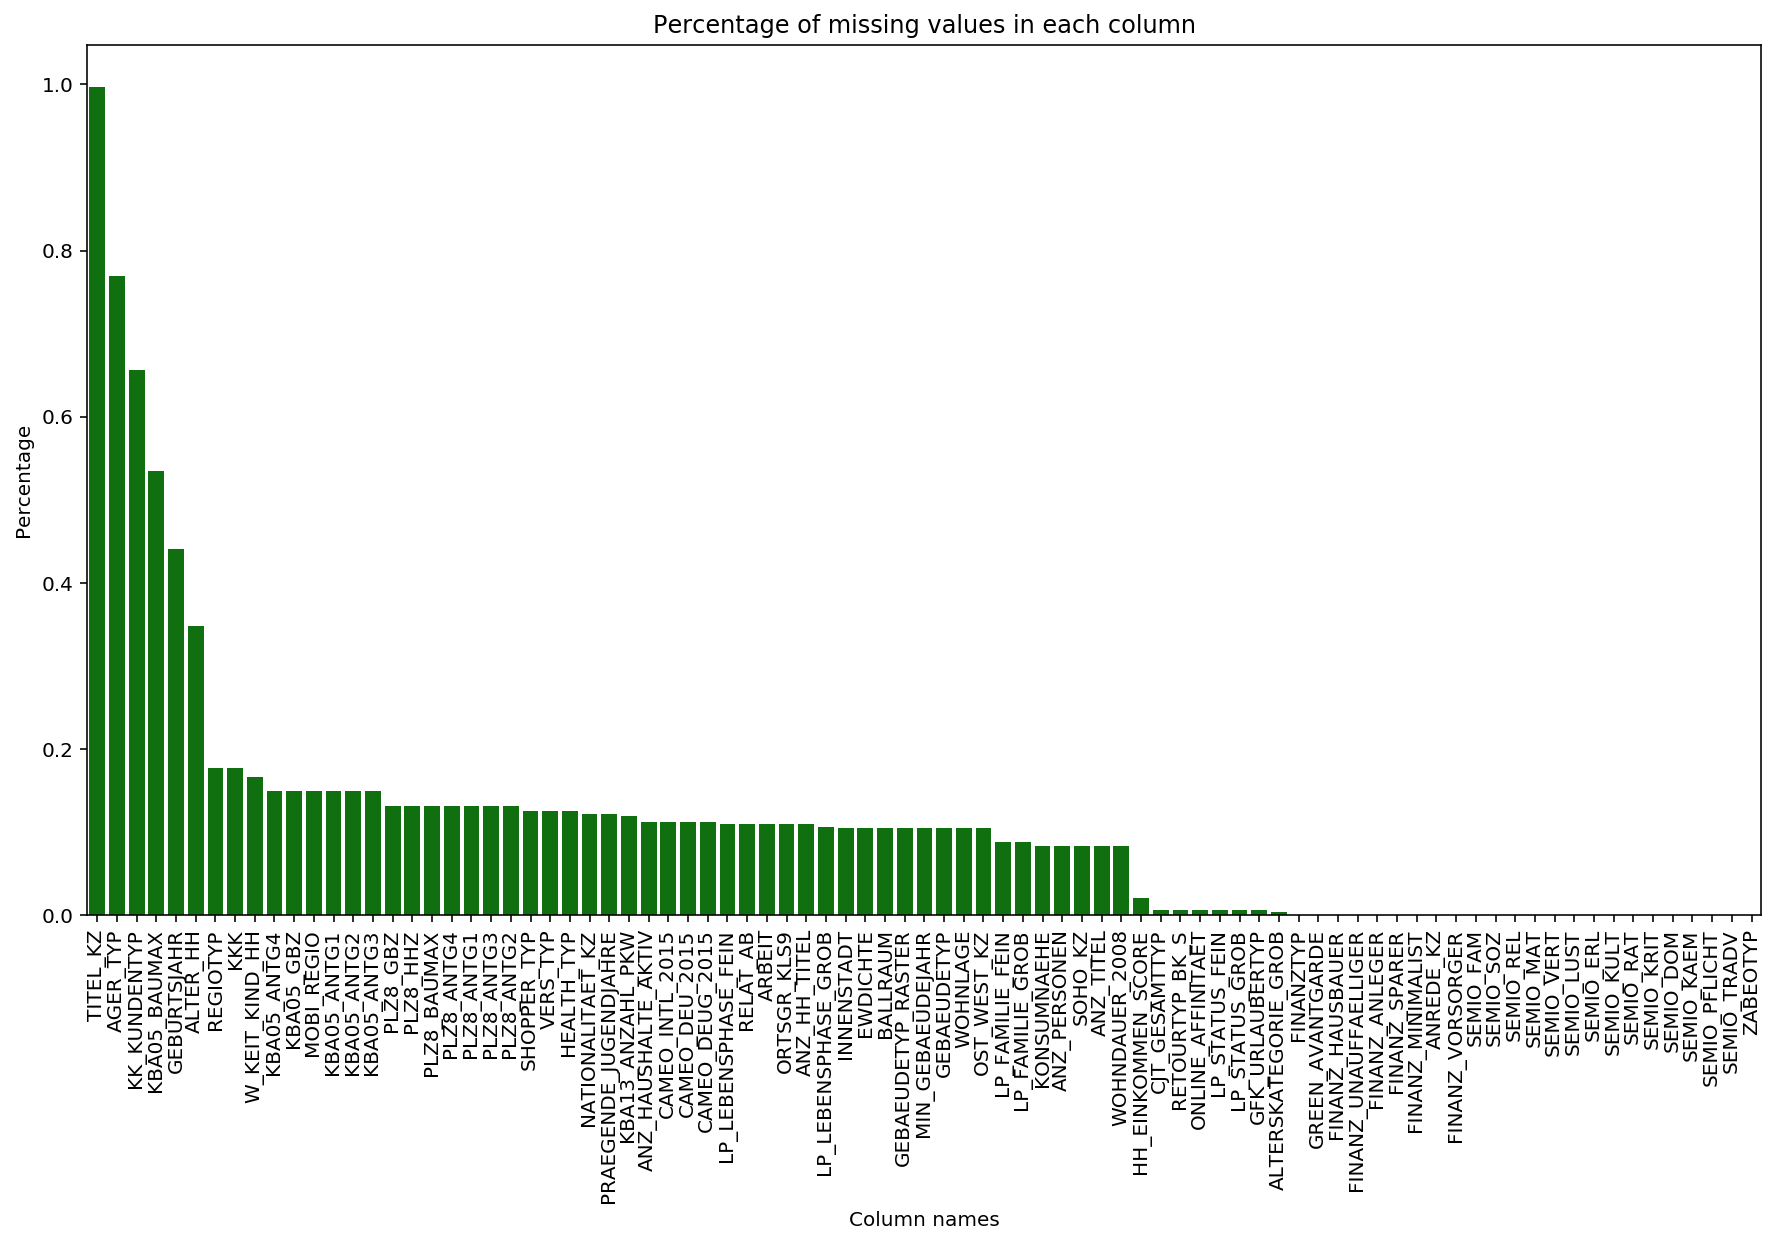

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.title('Percentage of missing values in each column')
plot_order = missing['missing_per'].sort_values(ascending=False).index
sns.barplot(x= missing.index, y= missing['missing_per'], order = plot_order, color = 'g')
plt.xlabel('Column names')
plt.ylabel('Percentage')
plt.show()

In [30]:
#Find the column that missing values are greater than 30% 
drop_col = missing[missing['missing_per'] > 0.3].index.tolist()
print(drop_col)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [31]:
#Investigate the pattern of missing values
feat_info[feat_info['attribute'].isin(drop_col)]

attribute information_level         type missing_or_unknown
0       AGER_TYP            person  categorical             [-1,0]
11   GEBURTSJAHR            person      numeric                [0]
40      TITEL_KZ            person  categorical             [-1,0]
43      ALTER_HH         household     interval                [0]
47  KK_KUNDENTYP         household  categorical               [-1]
64  KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]

In [32]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(drop_col,axis=1)
azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 3          4    ...            NaN         NaN         NaN   
1                 5          1    ...            2.0         3.0         2.0   
2                 5          1    ...            3.0         3.0         1.0   
3                 2          6    ...            2.0         2.0         2.0   
4                 2          5    ...            2.0         4.0         2.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0         NaN          NaN       NaN       NaN     NaN          NaN       NaN  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  

[5 rows x 79 columns]

We drop 6 columns, and 79 columns remaining.

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

We remove 6 columns that have more than 30% of data are missing to ensure our analytics quality later on. 

The columns we drop include
- AGER_TYP: Best-ager typology
- GEBURTSJAHR: Year of birth
- TITEL_KZ: Academic title flag (Dr., Prof., etc)
- ALTER_HH: Birthdate of the head of household
- KK_KUNDENTYP: Consumer pattern over past 12 months
- KBA05_BAUMAX: Most common building type within the microcell

Besides three columns are related to age, there isn't a specific pattern for columns we drop.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [33]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)
missing_row[:20]

0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
dtype: int64

Text(0.5,1,'Missing rows count')

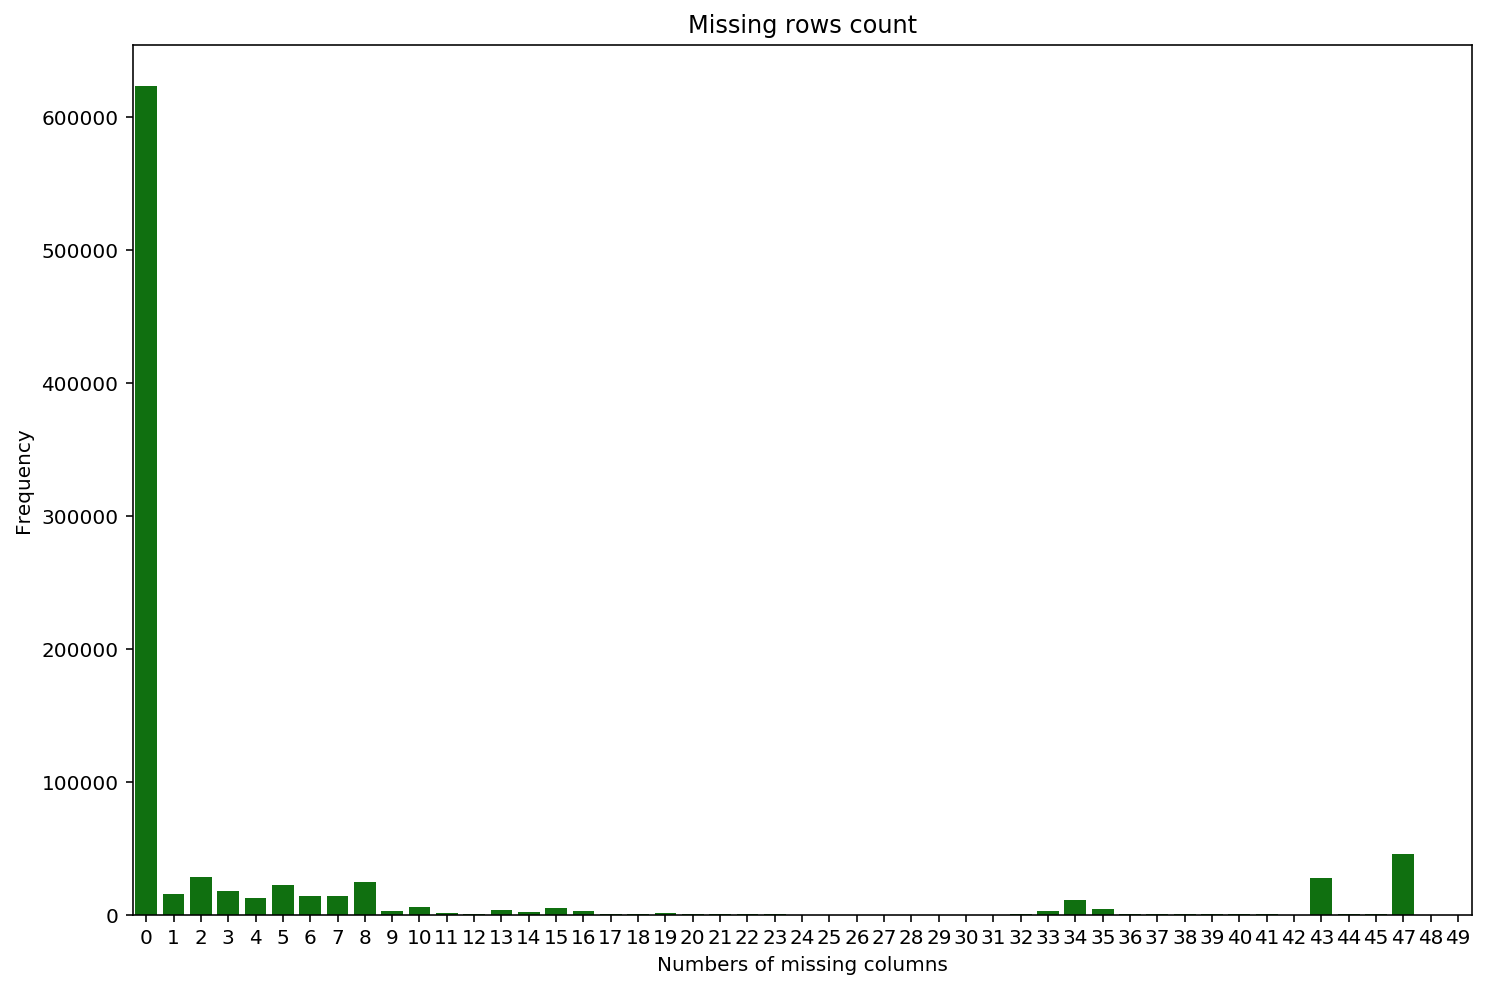

In [34]:
plt.figure(figsize=(12,8))
sns.countplot(x=missing_row, color = 'g')
plt.xlabel('Numbers of missing columns')
plt.ylabel('Frequency')
plt.title('Missing rows count')

In [35]:
azdias['num_missing_row']= missing_row

#Divide the data into two subsets: one for data points that are above some threshold for missing values, 
#and a second subset for points below that threshold.

#threshold = 20
many_missing_row = azdias[azdias['num_missing_row'] >= 10]
few_missing_row = azdias[azdias['num_missing_row'] < 10]
many_missing_row.shape, few_missing_row.shape

((116478, 80), (774743, 80))

In [36]:
#Columns with no missing 
missing[missing['missing_count'] == 0].index

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

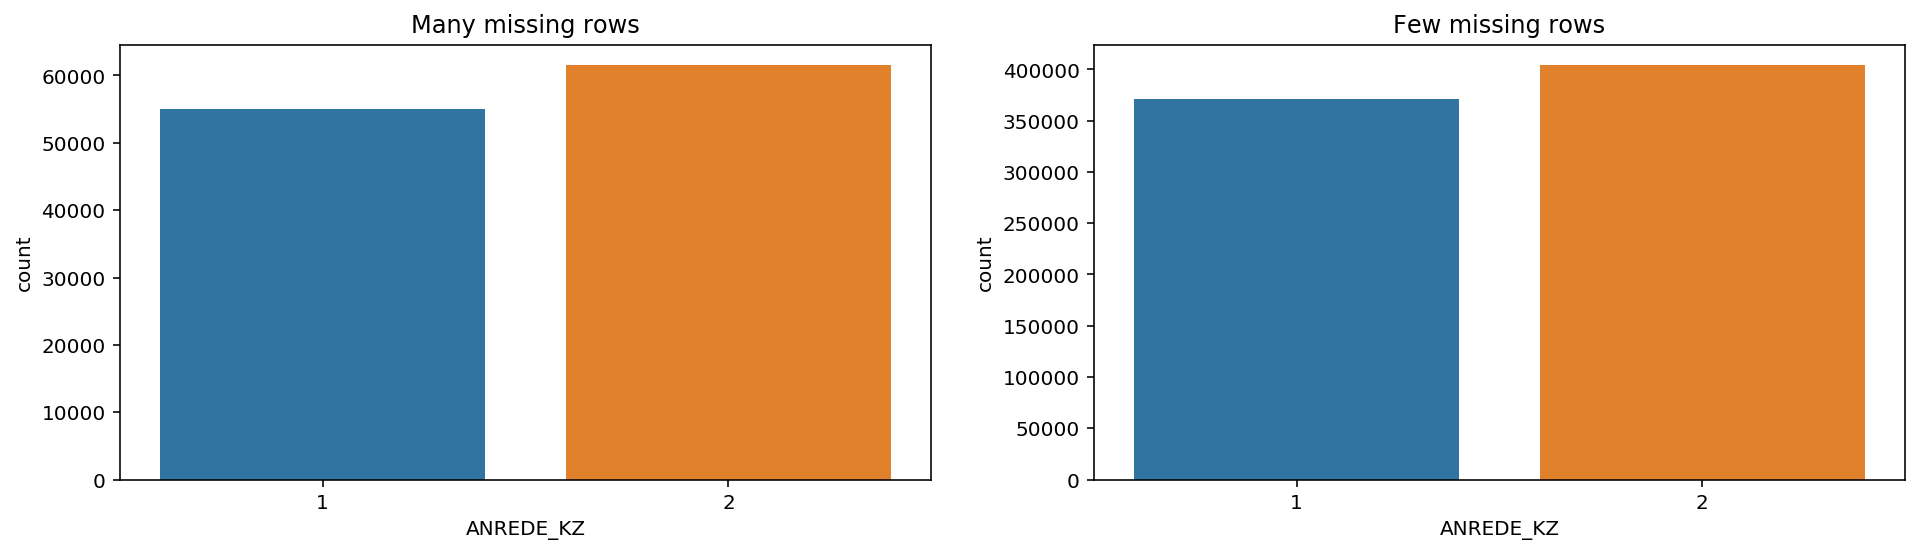

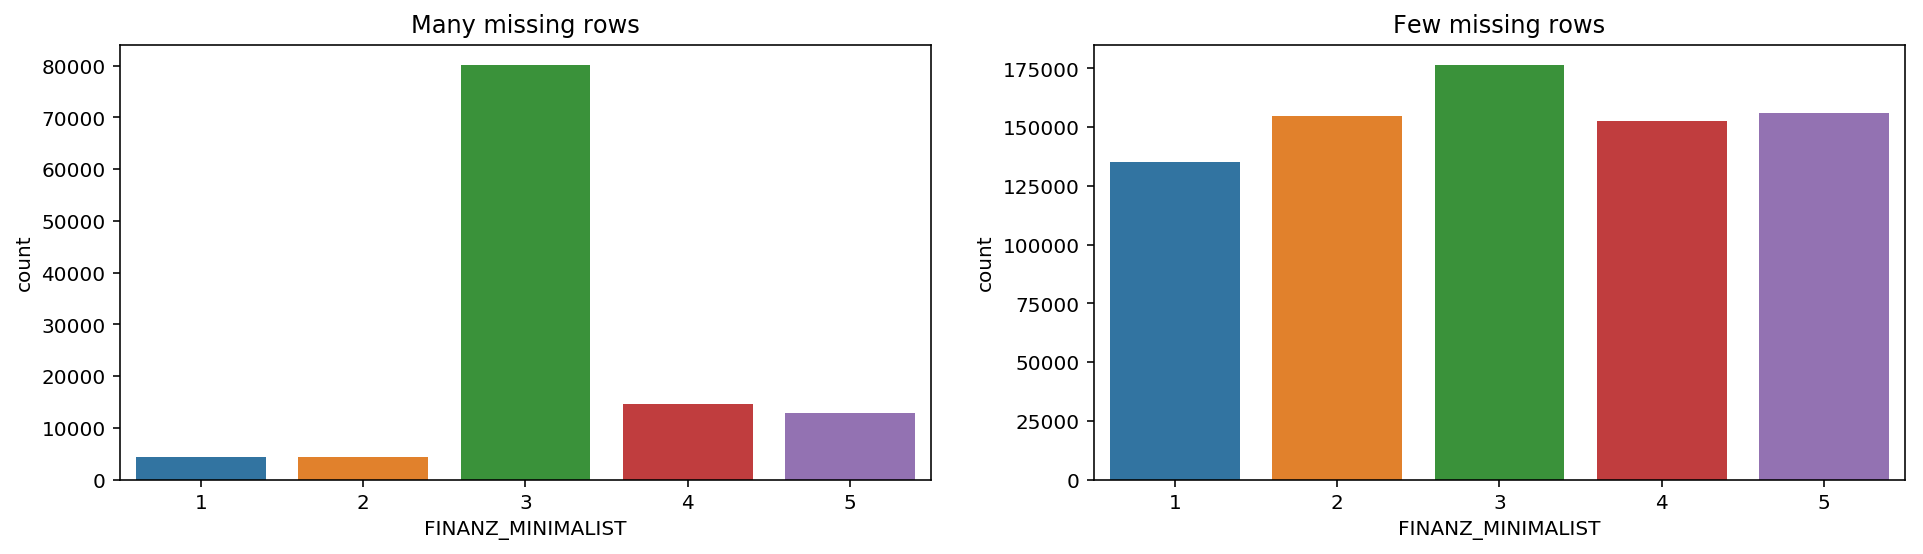

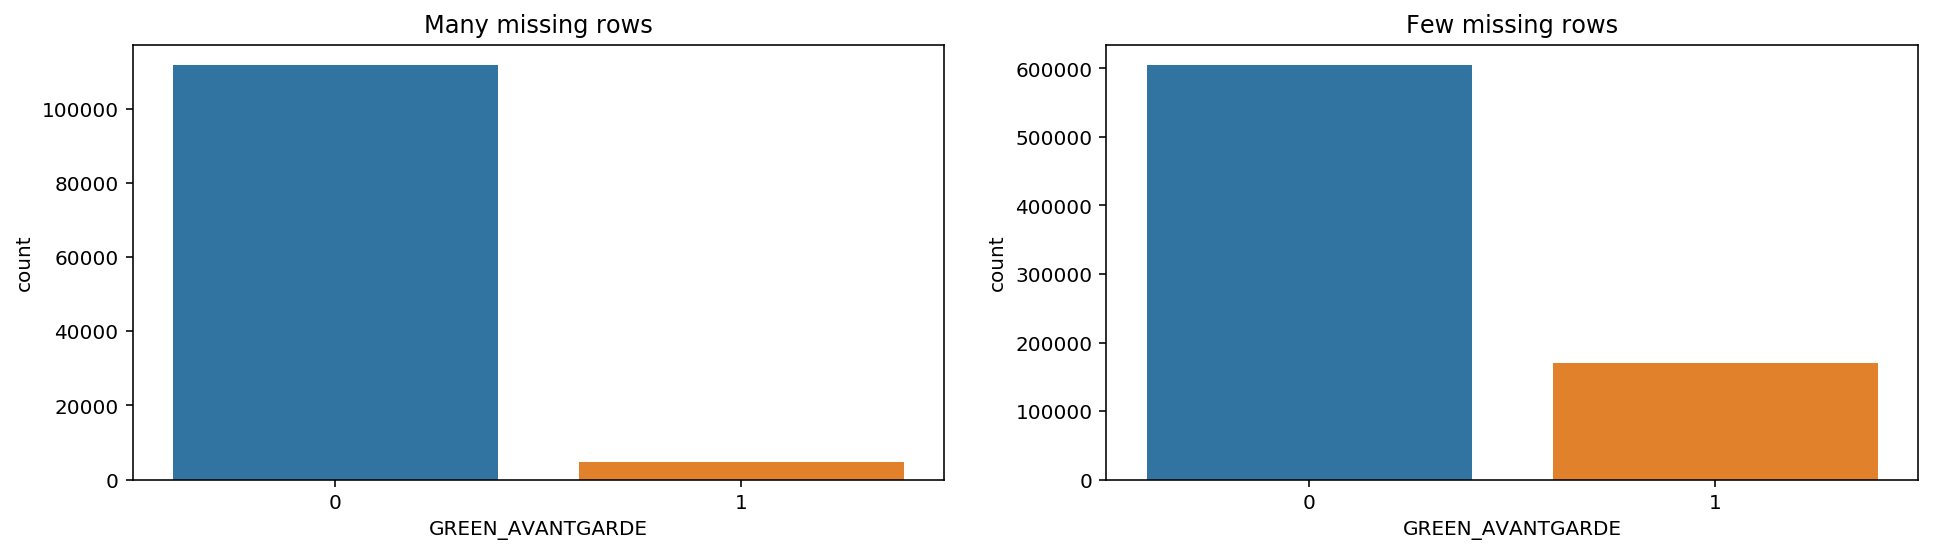

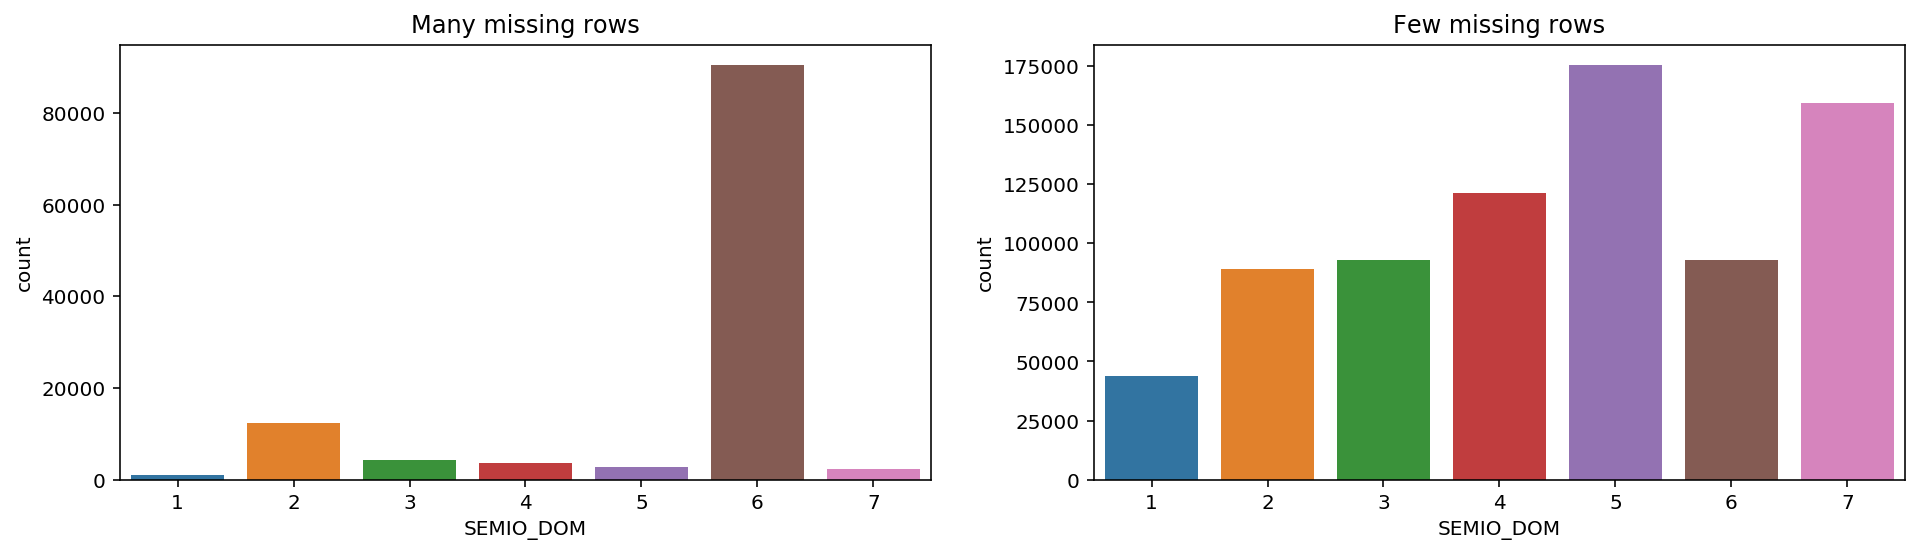

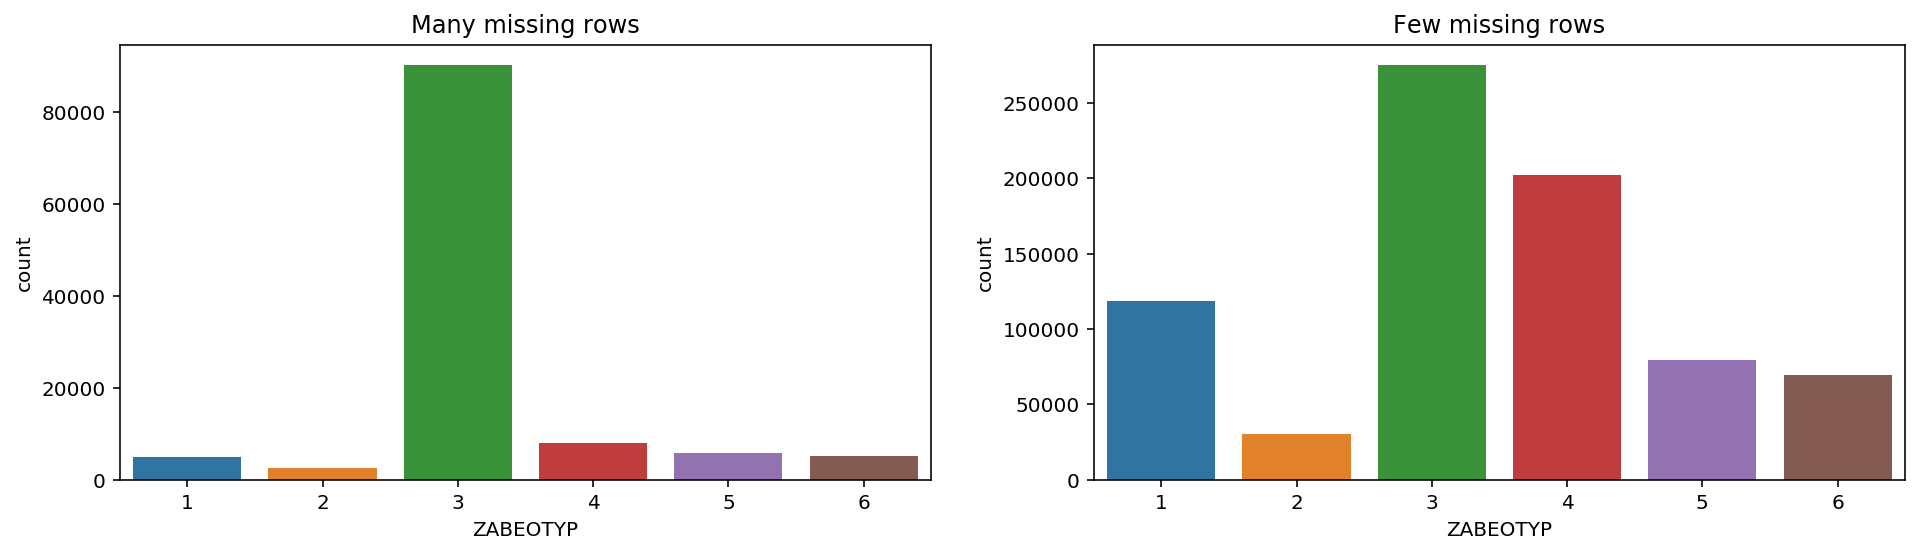

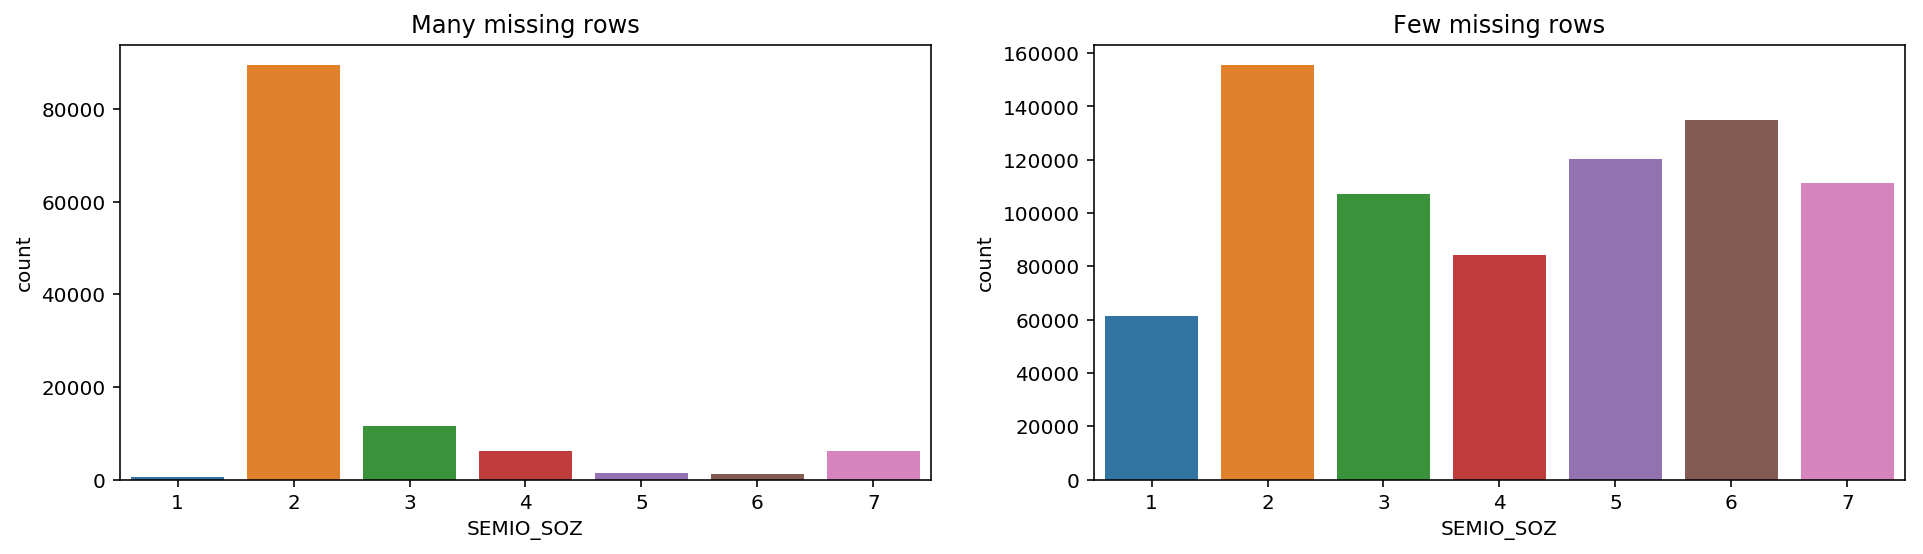

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fiv_col = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_DOM', 'ZABEOTYP', 'SEMIO_SOZ']

def compare_plot(col):
    '''
    input: column name:
    output
    '''
    
    fig = plt.figure(figsize=(16,4))
    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1.title.set_text('Many missing rows')
    sns.countplot(many_missing_row[col])
    
    ax2 = plt.subplot2grid((1,2), (0,1))
    ax2.title.set_text('Few missing rows')
    sns.countplot(few_missing_row[col])

    plt.show()

for col in fiv_col:
    compare_plot(col)

In [38]:
#only select rows with few missing values
azdias = few_missing_row

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see missing data has a different distribution than non-missing data. Since a variable might relate to the distribution and the reason why the data are missing, we will want to consider missing data later on. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [39]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
category_col = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
category_col

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [41]:
#Print out numbers of the unquie columns if they are categorical and presented in azdias 
for col in category_col:
    if col in azdias.columns: 
        print(col, azdias[col].nunique())


ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44


In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.

#create two lists, one stores multilevel categorical data, the other stores binary categorical data
multi_category = []
bi_category = []
for col in category_col:
    if col in azdias.columns: 
        if azdias[col].nunique() > 2:
            multi_category.append(col)
        else:
            bi_category.append(col)
print(multi_category)
print(bi_category)


#drop the columns that are multilevel categorical datat
azdias.drop(multi_category, axis=1, inplace=True)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [43]:
#the binary variable that takes non-numeric values 
print(azdias['ANREDE_KZ'].unique())
print(azdias['GREEN_AVANTGARDE'].unique())
print(azdias['SOHO_KZ'].unique())
print(azdias['VERS_TYP'].unique())
print(azdias['OST_WEST_KZ'].unique())

[2 1]
[0 1]
[ 1.  0.]
[  2.   1.  nan]
['W' 'O']


In [44]:
#re-encode binary columns
azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [45]:
#verify the result
print(azdias['ANREDE_KZ'].unique())
print(azdias['GREEN_AVANTGARDE'].unique())
print(azdias['SOHO_KZ'].unique())
print(azdias['VERS_TYP'].unique())
print(azdias['OST_WEST_KZ'].unique())

[1 0]
[0 1]
[ 1.  0.]
[  1.   0.  nan]
[1 0]


#### Discussion 1.2.1: Re-Encode Categorical Features

Excluding the variables we drop, there are 18 categorical variables, 13 of which are multilevel and 5 are binary. We drop the multilevel variables to keep our analysis more straightforward. In addition, we change all the binary variables into 1 and 0 so they can be used in the algorithm. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias[['PRAEGENDE_JUGENDJAHRE']].head()

PRAEGENDE_JUGENDJAHRE
1                   14.0
2                   15.0
3                    8.0
4                    8.0
5                    3.0

**PRAEGENDE_JUGENDJAHRE**

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [47]:
def define_decade(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6
    
def define_movement(x):
    if x in (2,4,6,7,9,11,13,15): #Avantgarde
        return 0
    elif x in (1,3,5,8,10,12,14): #Mainstream
        return 1 

In [48]:
#engineer two new variables: decade and movement
azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(define_decade)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(define_movement)

In [49]:
#drop the column 
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias[['CAMEO_INTL_2015']].head()

CAMEO_INTL_2015
1              51
2              24
3              12
4              43
5              54

**4.3. CAMEO_INTL_2015**

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [51]:
# Adding a feature based on wealth
def cameo_wealth(x):
    if x // 10 ==1: #Wealthy Households
        return 1
    if x // 10 ==2: #Prosperous Households
        return 2
    if x // 10 ==3: #Comfortable Households
        return 3
    if x // 10 ==4: #Less Affluent Households
        return 4
    if x // 10 ==5: #Poorer Households
        return 5

# Adding a feature based on lfe stage
def cameo_life_stage(x):
    if x % 10 ==1: #Pre-Family Couples & Singles
        return 1
    if x % 10 ==2: #Young Couples With Children
        return 2
    if x % 10 ==3: #Families With School Age Children
        return 3
    if x % 10 ==4: #Older Families &  Mature Couples
        return 4
    if x % 10 ==5: #Elders In Retirement
        return 5

In [52]:
azdias['CAMEO_INTL_2015'].dtypes #type is a string 

#convert to numeric
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [53]:
#engineer two new variables: wealth and life stage
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(cameo_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(cameo_life_stage)

In [54]:
#drop the column
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For variable PRAEGENDE_JUGENDJAHRE, we re-engineer it into two variables
1. A person's decade of youth: 
    - 40s
    - 50s
    - 60s
    - 70s
    - 80s
    - 90s
2. A person's movement: 
    - avantgarde
    - mainstream

We drop PRAEGENDE_JUGENDJAHRE, and create two new variables DECADE and MOVEMENTS. 


For variable CAMEO_INTL_2015, we re-engineer it into two variables
1. The level of wealth: 
    - wealth
    - prosperous
    - comfortable
    - less affluent
    - poorer
2. The life stage of a person: 
    - Pre-Family Couples & Singles
    - Young Couples With Children
    - Families With School Age Children
    - Older Families &  Mature Couples
    - Elders In Retirement
    
We drop CAMEO_INTL_2015, and create two new variables WEALTH and LIFE_STAGE. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [55]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
for col in azdias.columns:
    print(col, azdias[col].dtypes)

ALTERSKATEGORIE_GROB float64
ANREDE_KZ int64
FINANZ_MINIMALIST int64
FINANZ_SPARER int64
FINANZ_VORSORGER int64
FINANZ_ANLEGER int64
FINANZ_UNAUFFAELLIGER int64
FINANZ_HAUSBAUER int64
GREEN_AVANTGARDE int64
HEALTH_TYP float64
LP_LEBENSPHASE_FEIN float64
LP_LEBENSPHASE_GROB float64
RETOURTYP_BK_S float64
SEMIO_SOZ int64
SEMIO_FAM int64
SEMIO_REL int64
SEMIO_MAT int64
SEMIO_VERT int64
SEMIO_LUST int64
SEMIO_ERL int64
SEMIO_KULT int64
SEMIO_RAT int64
SEMIO_KRIT int64
SEMIO_DOM int64
SEMIO_KAEM int64
SEMIO_PFLICHT int64
SEMIO_TRADV int64
SOHO_KZ float64
VERS_TYP float64
ANZ_PERSONEN float64
ANZ_TITEL float64
HH_EINKOMMEN_SCORE float64
W_KEIT_KIND_HH float64
WOHNDAUER_2008 float64
ANZ_HAUSHALTE_AKTIV float64
ANZ_HH_TITEL float64
KONSUMNAEHE float64
MIN_GEBAEUDEJAHR float64
OST_WEST_KZ int64
WOHNLAGE float64
KBA05_ANTG1 float64
KBA05_ANTG2 float64
KBA05_ANTG3 float64
KBA05_ANTG4 float64
KBA05_GBZ float64
BALLRAUM float64
EWDICHTE float64
INNENSTADT float64
GEBAEUDETYP_RASTER float64
KKK floa

In [56]:
azdias.drop('num_missing_row', axis=1, inplace=True)

In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.isnull().sum()/len(azdias) #double check missing columns

ALTERSKATEGORIE_GROB     0.003351
ANREDE_KZ                0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.043137
LP_LEBENSPHASE_FEIN      0.053895
LP_LEBENSPHASE_GROB      0.050453
RETOURTYP_BK_S           0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
SOHO_KZ                  0.000000
VERS_TYP                 0.043137
ANZ_PERSONEN  

In [58]:
azdias.isnull().sum(axis=1) #double check missing rows 

1         0
2         0
3         5
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        6
13        8
15        8
16        4
18        3
19        0
21        0
22        0
23        8
25        3
27        0
28        0
29        2
31        0
32        0
33        0
34        2
36        0
37        0
38        0
         ..
891190    0
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    0
891208    3
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    3
891217    2
891218    3
891219    0
891220    0
Length: 774743, dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [59]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # 1. convert missing value codes into NaNs
    columns = df.columns
    for col in columns: 

        missing = feat_info[feat_info['attribute'] == col]['missing_or_unknown']
        
        #change the panda series into a string
        missing_str = missing.to_string(index = False).strip('[]')

        if missing_str != '':
            #change the string into a list
            missing_list =[x if x in ['X','XX'] else int(x) for x in missing_str.split(',')]
            
            #replace missing values in missing_list with nan 
            df[col] = df[col].replace(missing_list, np.nan)
    
    # 2. remove selected columns and rows
    # remove selected columns 
    drop_col = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(drop_col,axis=1)
    
    #find missing rows 
    missing_row = df.isnull().sum(axis=1)
    df['num_missing_row']= missing_row
    
    # remove missing rows 
    many_missing_row = df[df['num_missing_row'] >= 10]
    few_missing_row = df[df['num_missing_row'] < 10]
    print(f'{len(many_missing_row)} rows have many missing data')
    
    #few missing row as the new df
    df = few_missing_row
    df.drop('num_missing_row', axis=1, inplace=True)
    print(f'Total rows in dataset is {df.shape[0]}')

    
    #find multilevel categorical variables and drop it
    multi_category = []
    bi_category = []
    for col in category_col:
        if col in df.columns: 
            if df[col].nunique() > 2:
                multi_category.append(col)
            else:
                bi_category.append(col)
    
    df.drop(multi_category, axis=1, inplace=True)

    # encoding the 'OST_WEST_KZ' binary categorical column
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    
    # Engineering(converting) "PRAEGENDE_JUGENDJAHRE" and 'CAMEO_INTL_2015'into two new variables each     
    # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(define_decade)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(define_movement)

    # Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
        
    # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    #engineer two new variables: wealth and life stage
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(cameo_wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(cameo_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# copying azdias
azdias_copy = azdias.copy()
columns = azdias_copy.columns

In [61]:
#Test of how to use imputer 
imp_mean = Imputer(missing_values=np.nan, strategy='mean', axis = 0)
imp_mean.fit_transform([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

array([[  7. ,   2. ,   3. ],
       [  4. ,   3.5,   6. ],
       [ 10. ,   5. ,   9. ]])

In [62]:
#impute the data by mean
imputer = Imputer(strategy='mean', axis=0)
azdias_copy = imputer.fit_transform(azdias_copy)

In [63]:
#convert the array back to dataframe
azdias_copy = pd.DataFrame(azdias_copy, columns = columns)

azdias_copy.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
K

In [64]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_copy)
azdias_scaled = pd.DataFrame(azdias_scaled, columns= columns)
azdias_scaled.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -1.765007   0.958422          -1.488785       1.540017   
1              0.199492   0.958422          -1.488785       0.867244   
2              1.181742   0.958422           0.689233      -0.478302   
3              0.199492  -1.043381           0.689233       0.194471   
4             -1.765007   0.958422          -0.036773      -1.151076   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -1.044684        1.468541               0.981043          1.327209   
1         -1.770775       -0.568811               0.263375          1.327209   
2          1.133590       -0.568811              -1.171961         -0.818216   
3          0.407498       -1.247929               0.263375         -0.818216   
4          1.133590       -0.568811              -0.454293          1.327209   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0         -0.531136    1.077799     ...        -0.650851  1.432085  0.560706   
1          1.882757    1.077799     ...        -0.650851  0.399744  0.560706   
2         -0.531136   -0.276069     ...        -0.650851 -0.632597  0.560706   
3         -0.531136    1.077799     ...         0.037403 -0.632597 -0.343393   
4         -0.531136    1.077799     ...        -0.650851  1.432085  1.464805   

     ARBEIT  ORTSGR_KLS9  RELAT_AB   DECADES  MOVEMENTS    WEALTH  LIFE_STAGE  
0 -0.175332    -0.133626  0.679067  1.168230   0.551870  1.179748   -1.259894  
1 -0.175332    -0.133626 -0.796120  1.168230  -1.873696 -0.871766    0.760743  
2 -1.180995    -1.004475 -0.058527 -0.226391   0.551870 -1.555604   -0.586348  
3  0.830331     0.301799  1.416660 -0.226391   0.551870  0.495910    0.087197  
4 -1.180995    -1.004475 -0.058527 -1.621012   0.551870  1.179748    0.760743  

[5 rows x 68 columns]

### Discussion 2.1: Apply Feature Scaling

We copy the data frame and impute the mean for the missing data. The reason to impute data is to decrease information loss when deleting them. Yet, we might suffer some inaccuracy from imputation. As for StandardScaler, we decide to use it to create an isotropic dataset by reducing the variance of variables. The reason for choosing standardization over other methods is because the K-means clustering we will perform is isotropic in all directions of space so we prefer round than elongated clusters. StandardScaler gives equal importance to every variable. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.
all_components = len(columns)
pca_model = PCA(all_components)
pca_features = pca_model.fit_transform(azdias_scaled)

In [66]:
# Investigate the variance accounted for by each principal component.
pca_features.shape

(774743, 68)

In [67]:
print(len(pca_model.explained_variance_ratio_))
print(pca_model.explained_variance_ratio_)

#Accumulative sum of explain variance ration
np.cumsum(pca_model.explained_variance_ratio_)


68
[  1.73855043e-01   1.28103951e-01   8.92564501e-02   5.58775497e-02
   4.05264310e-02   3.27183551e-02   3.04905689e-02   2.54677024e-02
   2.26003203e-02   2.07701075e-02   1.98140356e-02   1.91608342e-02
   1.78711965e-02   1.68742957e-02   1.57356460e-02   1.54885285e-02
   1.47037729e-02   1.38565066e-02   1.24913691e-02   1.23354484e-02
   1.18268296e-02   1.13074365e-02   1.11286342e-02   1.06474097e-02
   1.03955344e-02   9.33248601e-03   8.76066339e-03   7.49278033e-03
   7.43607103e-03   7.14390174e-03   6.83613896e-03   6.59196814e-03
   6.46389191e-03   6.16192977e-03   5.94655462e-03   5.80464291e-03
   5.62104211e-03   5.10334348e-03   4.77042284e-03   4.63876798e-03
   4.22301527e-03   4.07070316e-03   3.86018596e-03   3.80036504e-03
   3.74071997e-03   3.64273434e-03   3.55087638e-03   3.42531488e-03
   3.23787263e-03   2.98826954e-03   2.93948027e-03   2.81909913e-03
   2.63245148e-03   2.51609205e-03   2.40622352e-03   2.36313189e-03
   2.13051192e-03   2.08833809e

array([ 0.17385504,  0.30195899,  0.39121544,  0.44709299,  0.48761942,
        0.52033778,  0.55082835,  0.57629605,  0.59889637,  0.61966648,
        0.63948051,  0.65864135,  0.67651254,  0.69338684,  0.70912249,
        0.72461102,  0.73931479,  0.75317129,  0.76566266,  0.77799811,
        0.78982494,  0.80113238,  0.81226101,  0.82290842,  0.83330396,
        0.84263644,  0.85139711,  0.85888989,  0.86632596,  0.87346986,
        0.880306  ,  0.88689797,  0.89336186,  0.89952379,  0.90547034,
        0.91127499,  0.91689603,  0.92199937,  0.92676979,  0.93140856,
        0.93563158,  0.93970228,  0.94356247,  0.94736283,  0.95110355,
        0.95474629,  0.95829716,  0.96172248,  0.96496035,  0.96794862,
        0.9708881 ,  0.9737072 ,  0.97633965,  0.97885574,  0.98126197,
        0.9836251 ,  0.98575561,  0.98784395,  0.98987714,  0.99171478,
        0.9934726 ,  0.99512538,  0.99666658,  0.99789104,  0.99906493,
        0.99984441,  0.99995142,  1.        ])

If we have every variable as our component, there is very small explanation of variance for each component.

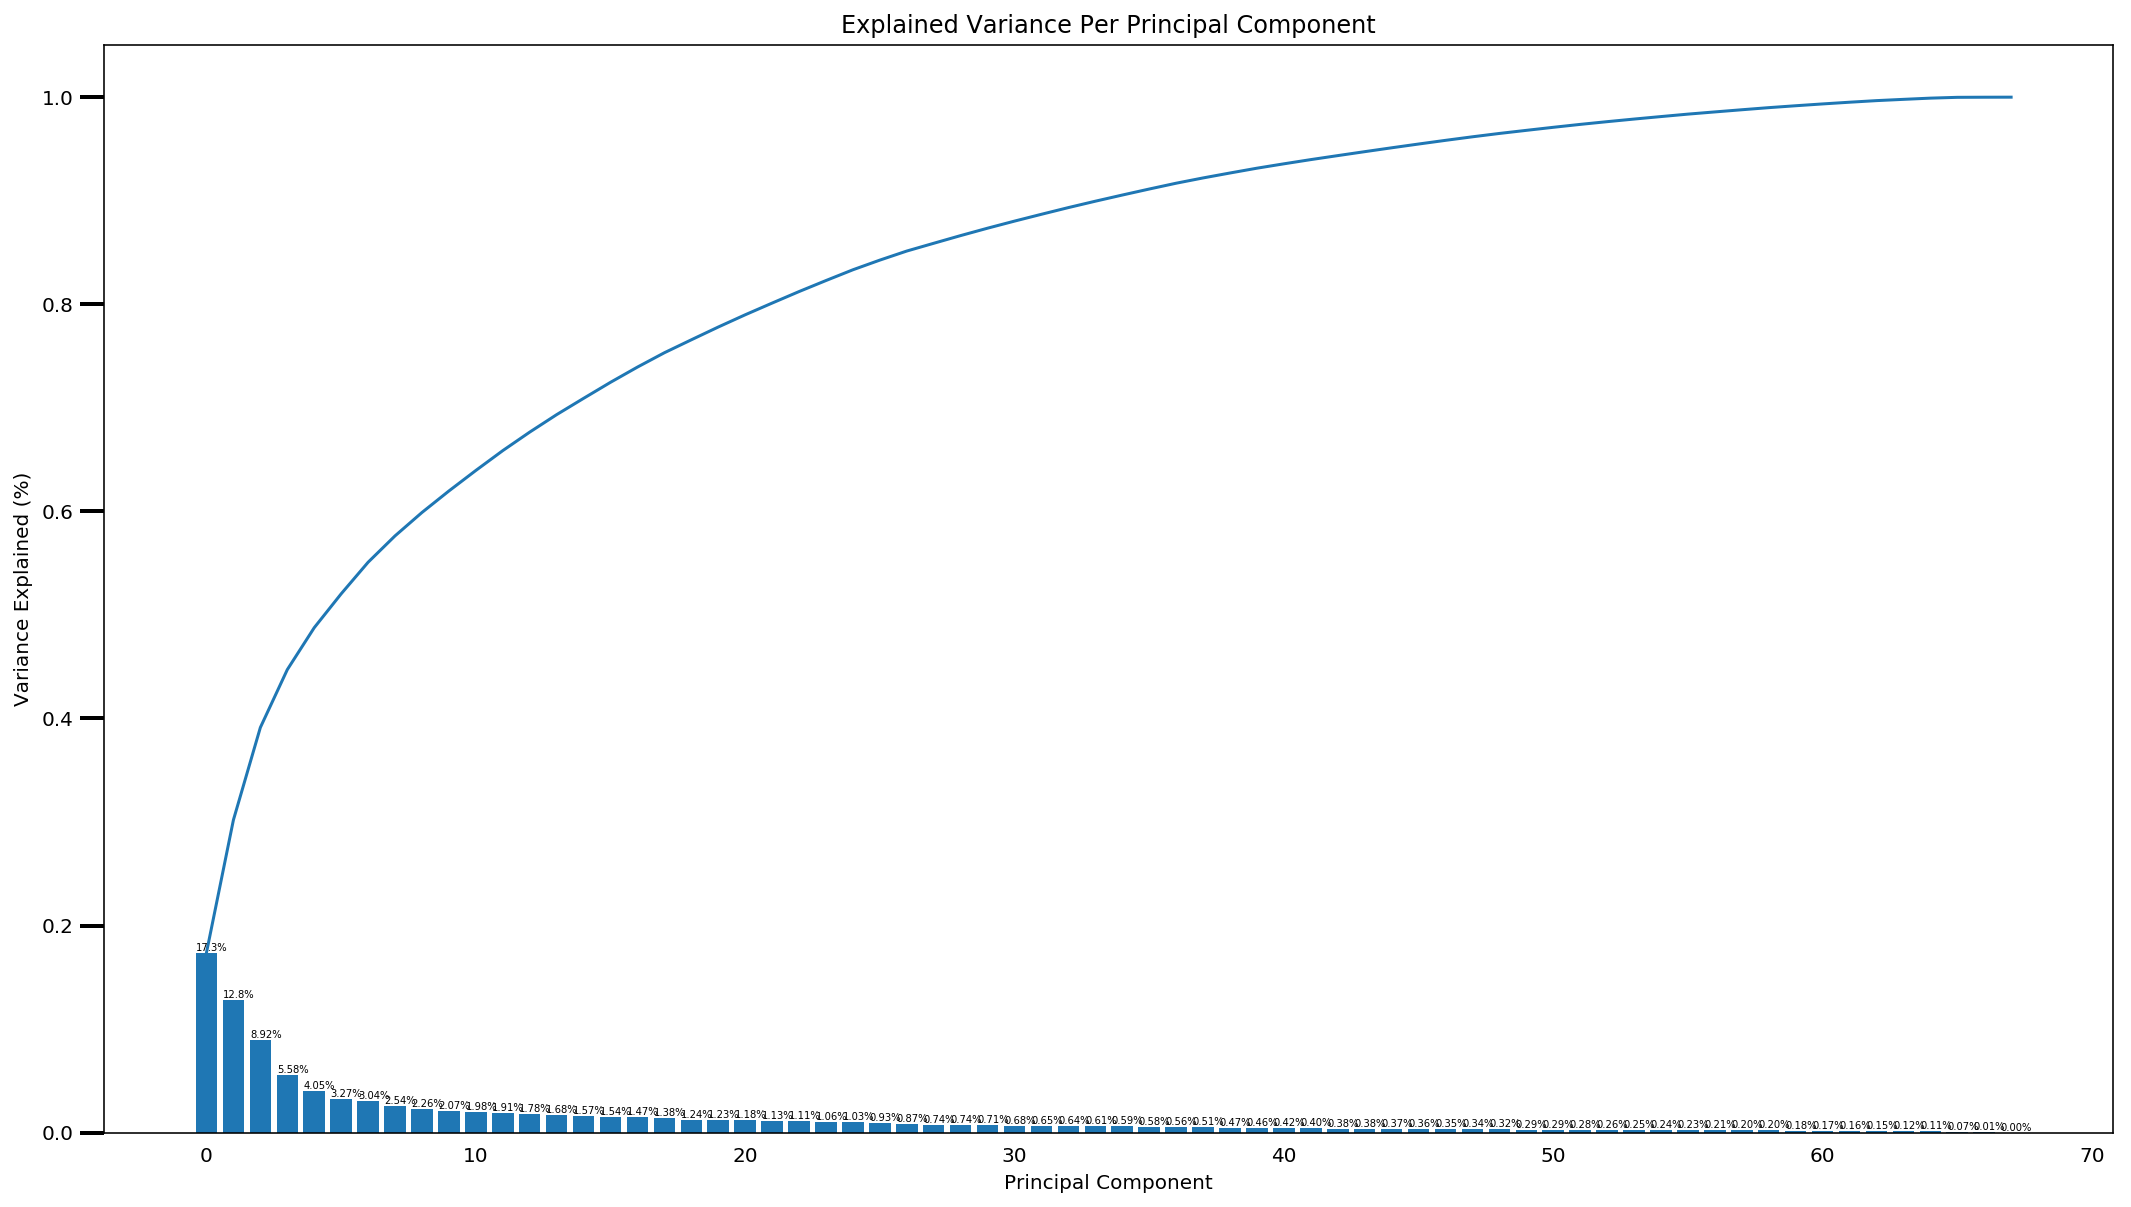

In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.

def scree_plot(pca): #from Udacity notes 
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize= 5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca_model)


In [69]:
#Reapply PCA with 25 components
pca_model_25 = PCA(25)
pca_features_25 = pca_model_25.fit_transform(azdias_scaled)

In [70]:
print(pca_features_25.shape)
print(np.cumsum(pca_model_25.explained_variance_ratio_))

(774743, 25)
[ 0.17385504  0.30195899  0.39121544  0.44709299  0.48761942  0.52033776
  0.55082832  0.57629599  0.59889631  0.61966629  0.63948022  0.65864077
  0.67651159  0.69338339  0.70911705  0.7246049   0.73930243  0.75315494
  0.76563253  0.77795407  0.7897769   0.80107856  0.81220344  0.82282712
  0.83317147]


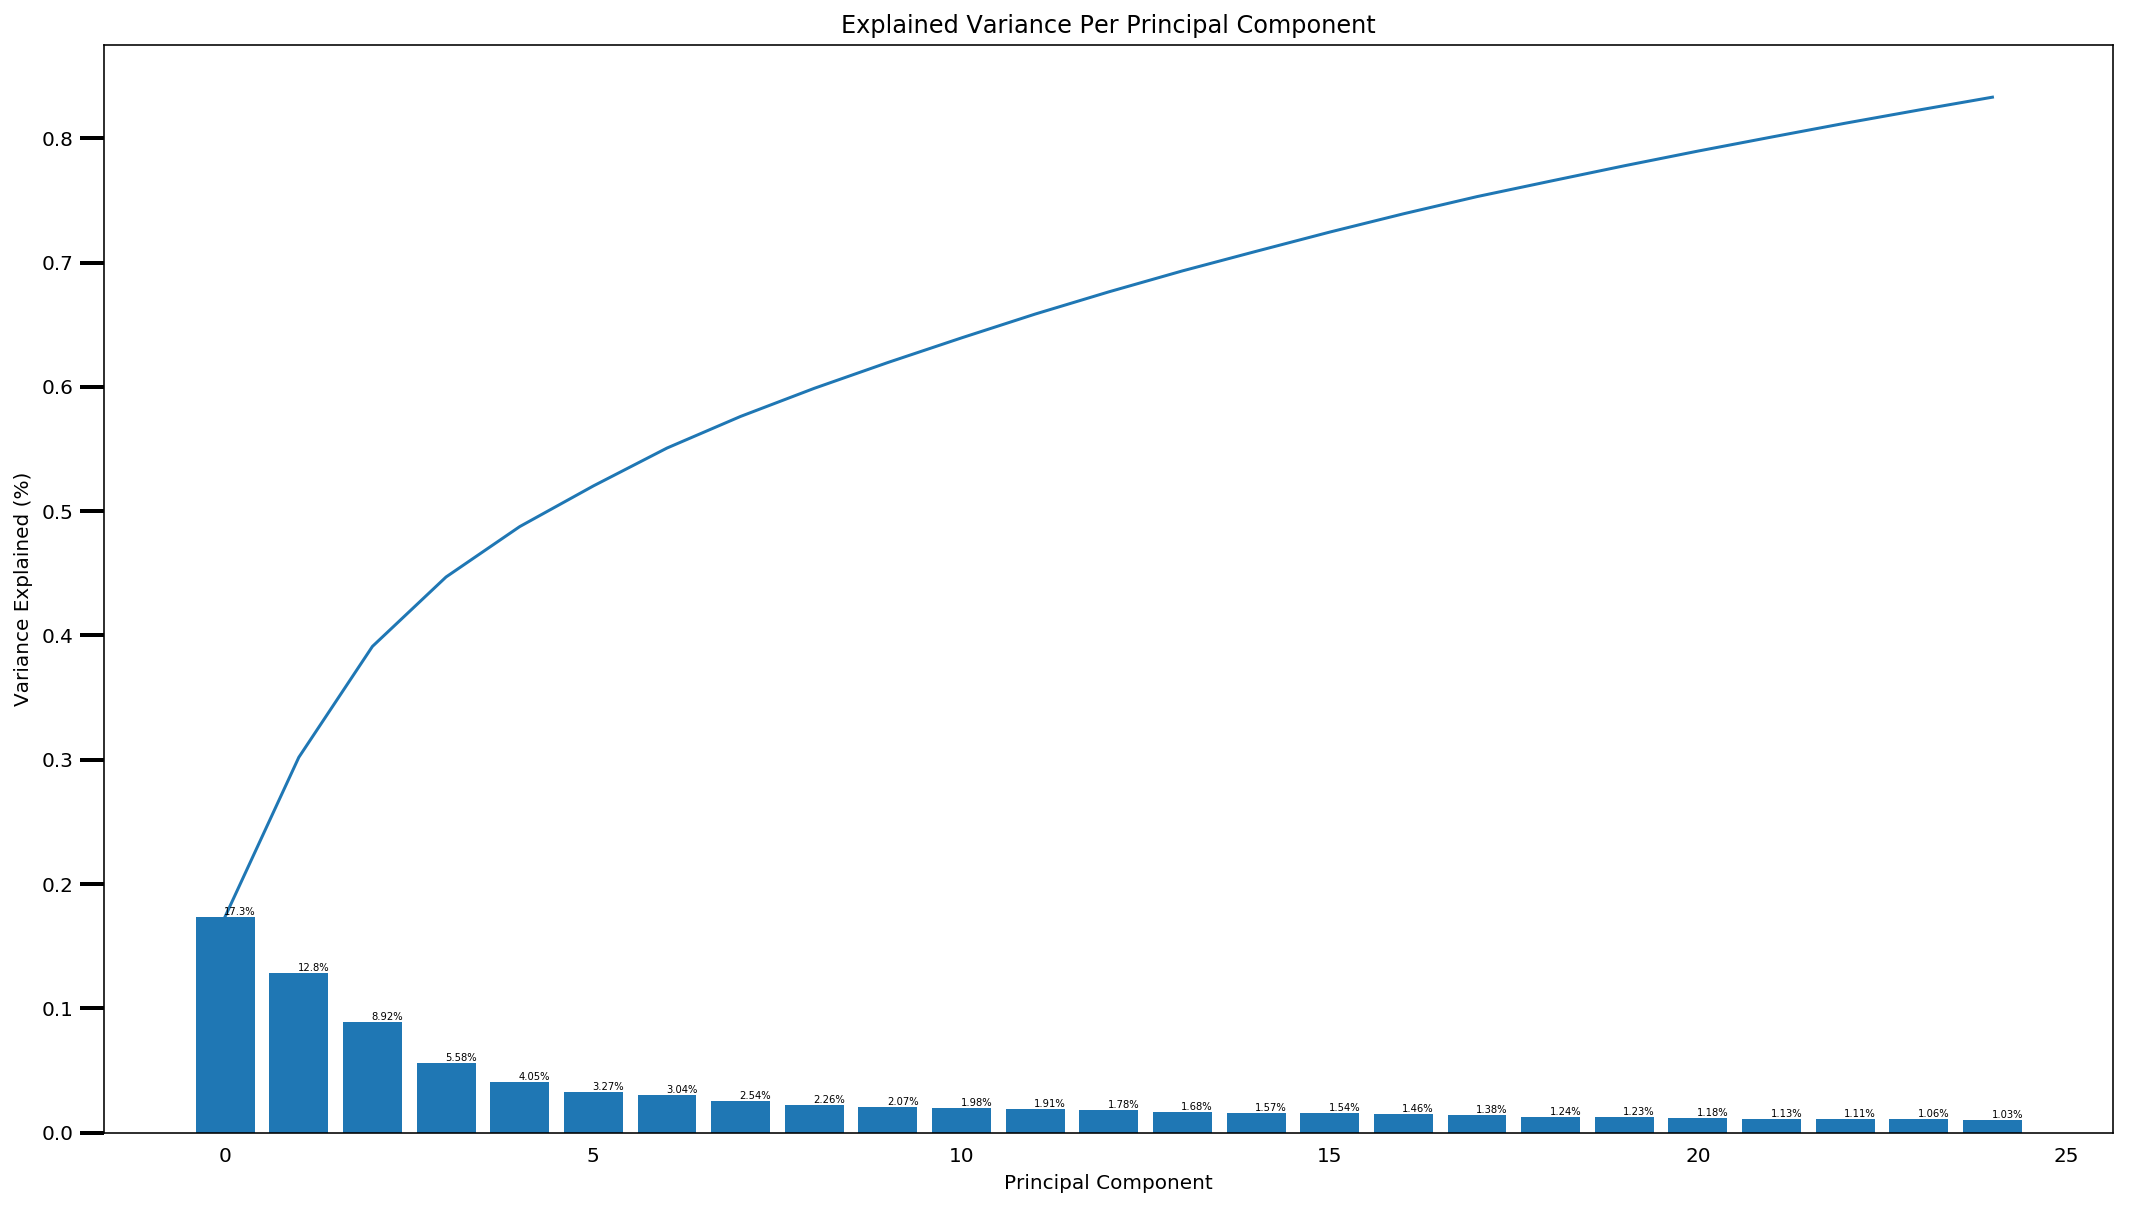

In [71]:
scree_plot(pca_model_25)

### Discussion 2.2: Perform Dimensionality Reduction

We apply `PCA()` method to the scaled dataset by observing the scree plot with accumulated explained variance. Here, we see that with 25 components, it accounts for around 83% of the variance. Therefore, we choose to use 25 components for clustering.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    
    #use the number of componenets to create dimensions 
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # use PCA components to create a dataframe: columns = variables, rows = component values
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.columns)
    components.index = dimensions#change index to dimensions 
    
    # PCA explained variance 
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    #make explained variance into a column format
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    return pd.concat([variance_ratios, components], axis = 1) #put explained variance and component df together 


def pca_plot(pca_results_df , nth_component):
    
    explain_variance = pca_results_df['Explained Variance'][:nth_component]
    accu_explain_variance = np.round(explain_variance.sum(),4)

    
    sort_comp = pca_results_df.iloc[nth_component-1].sort_values()
    head = sort_comp[:5]  #largest five variables in a component
    tail = sort_comp[-5:] #smallest five variables in a component
    components = pd.concat([head, tail])
    
    # Plot the components 
    components.plot(kind='bar', title='Component ' + str(nth_component), color = 'c')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)

    plt.show()
    print('Accumulative explained varaince for Component',nth_component,'is',accu_explain_variance)
    return components


In [73]:
pca_results_25 = pca_results(azdias_scaled, pca_model_25)
pca_results_25

Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1               0.1739               -0.0884     0.0102   
Dimension 2               0.1281                0.2715     0.0850   
Dimension 3               0.0893                0.0771    -0.3695   
Dimension 4               0.0559               -0.0384     0.0397   
Dimension 5               0.0405                0.0349    -0.0006   
Dimension 6               0.0327                0.0392    -0.0118   
Dimension 7               0.0305               -0.0088     0.0267   
Dimension 8               0.0255               -0.0395    -0.0546   
Dimension 9               0.0226               -0.0967     0.0931   
Dimension 10              0.0208               -0.0825    -0.0191   
Dimension 11              0.0198                0.1395     0.0248   
Dimension 12              0.0192               -0.0637    -0.0127   
Dimension 13              0.0179               -0.0234     0.0139   
Dimension 14              0.0169                0.0704    -0.0374   
Dimension 15              0.0157               -0.0326     0.0010   
Dimension 16              0.0155               -0.0884     0.0451   
Dimension 17              0.0147               -0.0008    -0.0009   
Dimension 18              0.0139               -0.1013     0.0387   
Dimension 19              0.0125                0.0375    -0.0189   
Dimension 20              0.0123                0.0367    -0.0093   
Dimension 21              0.0118                0.1002    -0.0345   
Dimension 22              0.0113               -0.0408     0.0198   
Dimension 23              0.0111               -0.1038     0.0533   
Dimension 24              0.0106               -0.0201     0.0361   
Dimension 25              0.0103                0.0800    -0.0390   

              FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
Dimension 1             -0.2000         0.1155           -0.0865   
Dimension 2              0.0946        -0.2513            0.2439   
Dimension 3              0.1613        -0.1051            0.0988   
Dimension 4              0.0628         0.0015           -0.0190   
Dimension 5              0.0383        -0.0005           -0.0235   
Dimension 6             -0.0616         0.0146            0.0526   
Dimension 7             -0.0160        -0.0012           -0.0437   
Dimension 8              0.0530         0.0351            0.0050   
Dimension 9              0.0663        -0.1685            0.1821   
Dimension 10             0.0442        -0.0664            0.1712   
Dimension 11            -0.1735         0.1600           -0.0670   
Dimension 12            -0.1600         0.0310            0.0435   
Dimension 13             0.0923        -0.0231           -0.0319   
Dimension 14             0.0645        -0.0168           -0.0249   
Dimension 15            -0.0607        -0.0083           -0.0168   
Dimension 16            -0.0271         0.0002            0.0212   
Dimension 17             0.0080        -0.0045            0.0018   
Dimension 18             0.0702        -0.1765            0.2296   
Dimension 19             0.0336         0.0487           -0.0732   
Dimension 20             0.0018         0.0146           -0.0043   
Dimension 21             0.0767         0.0166           -0.1141   
Dimension 22             0.0373        -0.0485            0.0389   
Dimension 23            -0.0216        -0.0327            0.1087   
Dimension 24            -0.0721         0.0904           -0.0444   
Dimension 25             0.0415        -0.0020           -0.0374   

              FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
Dimension 1           0.0426                 0.0497            0.1638   
Dimension 2          -0.2135                -0.2333            0.0938   
Dimension 3          -0.1880                -0.0960           -0.0512   
Dimension 4          -0.0956                 0.0677           -0.1040   
Dimension 5           0.0876                -0.0827           -0.0313   
Dimension 6 

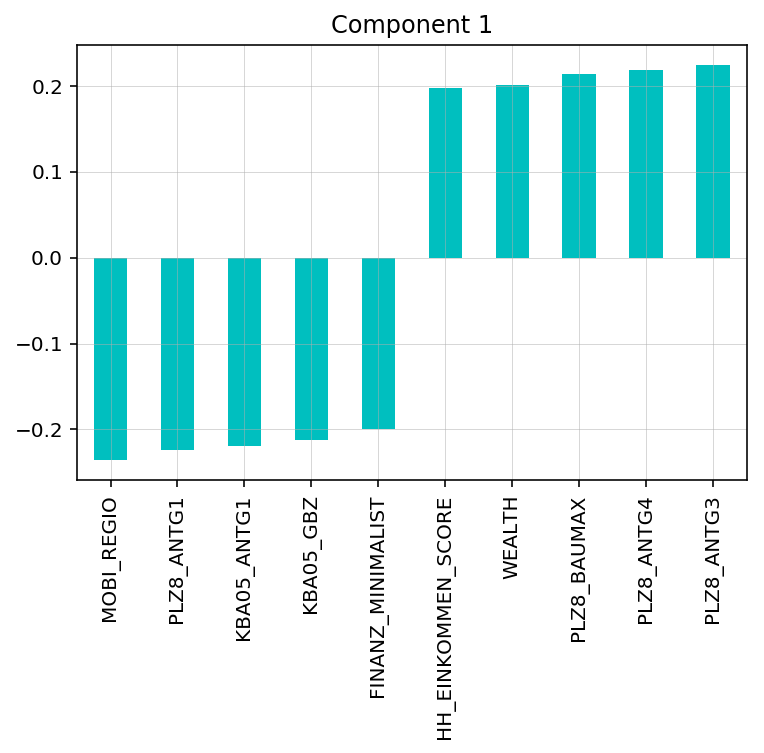

Accumulative explained varaince for Component 1 is 0.1739


MOBI_REGIO           -0.2361
PLZ8_ANTG1           -0.2238
KBA05_ANTG1          -0.2192
KBA05_GBZ            -0.2117
FINANZ_MINIMALIST    -0.2000
HH_EINKOMMEN_SCORE    0.1973
WEALTH                0.2013
PLZ8_BAUMAX           0.2139
PLZ8_ANTG4            0.2185
PLZ8_ANTG3            0.2243
Name: Dimension 1, dtype: float64

In [74]:
pca_plot(pca_results_25, 1)

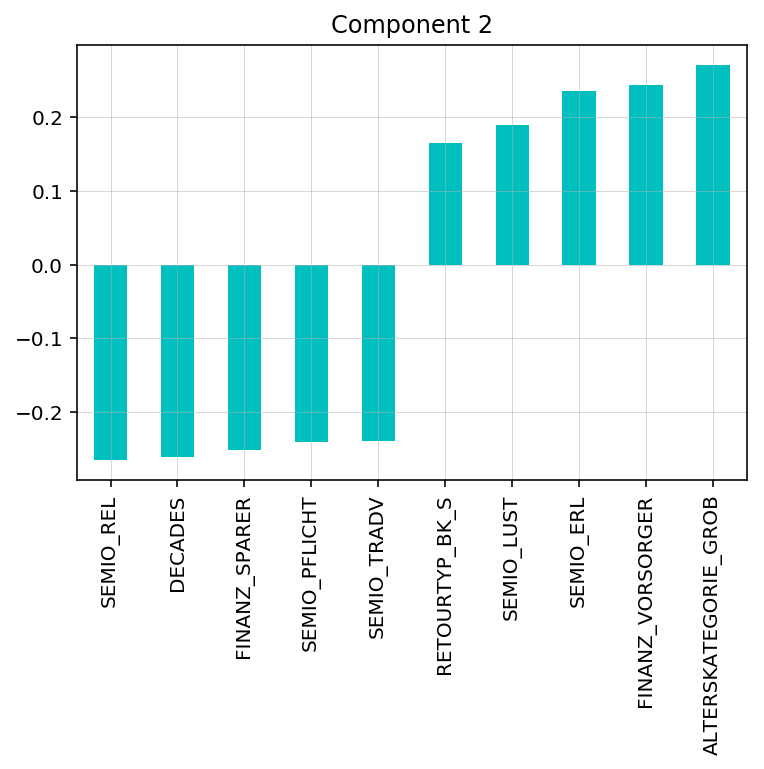

Accumulative explained varaince for Component 2 is 0.302


SEMIO_REL              -0.2651
DECADES                -0.2609
FINANZ_SPARER          -0.2513
SEMIO_PFLICHT          -0.2406
SEMIO_TRADV            -0.2393
RETOURTYP_BK_S          0.1654
SEMIO_LUST              0.1898
SEMIO_ERL               0.2351
FINANZ_VORSORGER        0.2439
ALTERSKATEGORIE_GROB    0.2715
Name: Dimension 2, dtype: float64

In [75]:
pca_plot(pca_results_25, 2)

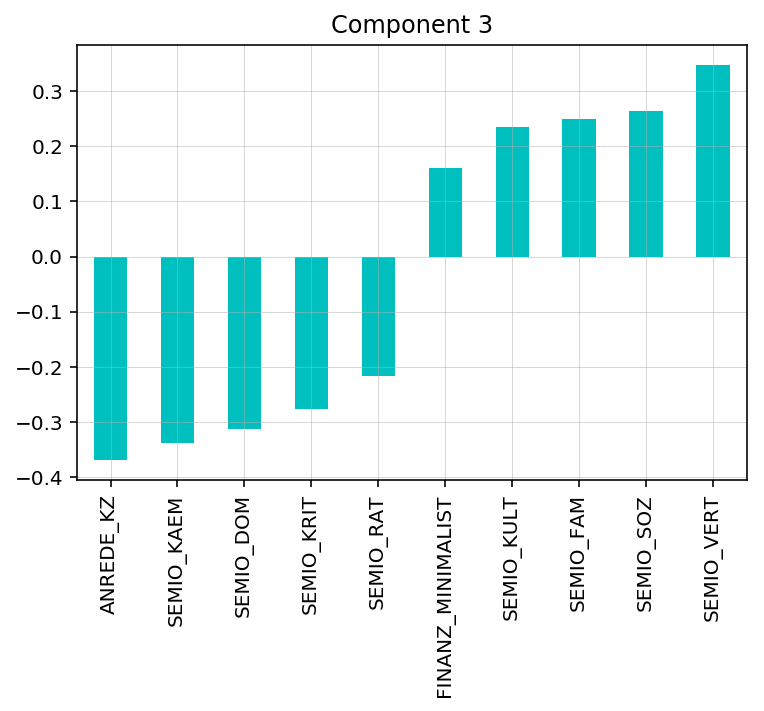

Accumulative explained varaince for Component 3 is 0.3913


ANREDE_KZ           -0.3695
SEMIO_KAEM          -0.3386
SEMIO_DOM           -0.3135
SEMIO_KRIT          -0.2755
SEMIO_RAT           -0.2160
FINANZ_MINIMALIST    0.1613
SEMIO_KULT           0.2351
SEMIO_FAM            0.2504
SEMIO_SOZ            0.2635
SEMIO_VERT           0.3476
Name: Dimension 3, dtype: float64

In [76]:
pca_plot(pca_results_25, 3)

### Discussion 2.3: Interpret Principal Components

We look into the top three components and analyze what it stands for. 

#### Component 1
- Positive association: 
   - PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region(high share: 2, no share: 0) 
   - PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region(high share: 2, no share: 0) 
   - PLZ8_BAUMAX: Most common building type for different numbers of homes within the PLZ8 region(mainly 1-2 family homes: 1, mainly 10+ family homes: 4, mainly business building 5) 
   - WEALTH  
   - HH_EINKOMMEN_SCORE: Estimated household net income(high income: 1, low income: 6) 
- Negative association: 
   - MOBI_REGIO: Movement patterns. (High movement: 5, Low movement: 1)
   - PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region(very high share of 1-2 family homes: 4, low share: 1) 
   - KBA05_ANTG1: Number of 1-2 family houses in the microcell(high share: 4, low share: 1) 
   - KBA05_GBZ: Number of buildings in the microcell(>=23 buildings: 5, 1-2 building: 1) 
   - FINANZ_MINIMALIST: Financial typology -- low financial interest(very high: 1, very low: 5)

For Component 1, its positive values related to PLZ8 indicate more members in the family. Wealth and household net income are both positive and related to financial conditions. **It describes people who live in a big family with lower income.**
**In contrast, strong negative values such as PLZ8_ANTG1, KBA05_ANTG1, and FINANZ_MINIMALIST indicate smaller family capacity with more financial affluence.**

We see that Component 1 is related to the size of the household and financial condition. 


#### Component 2
- Positive association: 
    - ALTERSKATEGORIE_GROB: Estimated age based on given name analysis(<30: 1, >60: 4) 
    - FINANZ_VORSORGER: Financial typology -- be prepared(very high: 1, very low: 5)
    - SEMIO_ERL: Personality typology -- event-oriented(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_LUST: Personality typology -- sensual-minded(highest affinity: 1, lowest affinity: 5) 
    - RETOURTYP_BK_S: Return type(influenceable Crazy-Shopper: 1, determined Minimal-Returner: 5)
- Negative association: 
    - SEMIO_REL: Personality typology -- religious(highest affinity: 1, lowest affinity: 5) 
    - DECADES: We extract this from the time of dominating movement of a person's youth(1: 40s , 6: 90s
    - FINANZ_SPARER: Personality typology -- money-saver(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_PFLICHT: Personality typology -- dutiful(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_TRADV: Personality typology -- tradional-minded(highest affinity: 1, lowest affinity: 5) 
    
As for Component 2, positive values are related to age and conservative personality. **It describes old people as being less event-oriented, less sensual-minded, less prepared in finance, and a conservative shopper.**
**As for negative values, it describes a liberal personality that young people being less religious, less traditional, less dutiful, less traditional-minded, and unlikely to save money.**

We see that Component 2 is related to age and liberal/conservative personality. 

#### Component 3
- Positive association: 
    - SEMIO_VERT: Personality typology -- dreamful(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_SOZ: Personality typology -- socially-minded(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_FAM: family-minded(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_KULT: cultural-minded(highest affinity: 1, lowest affinity: 5) 
    - FINANZ_MINIMALIST: Financial typology -- low financial interest(very high: 1, very low: 5)
- Negative association: 
    - ANREDE_KZ:Gender(male:1, female: 2) 
    - SEMIO_KAEM: Personality typology -- combative attitude(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_DOM: Personality typology -- dominant-minded(highest affinity: 1, lowest affinity: 5) (highest affinity: 1, lowest affinity: 5) 
    - SEMIO_KRIT: Personality typology -- critical-minded(highest affinity: 1, lowest affinity: 5) 
    - SEMIO_RAT: Personality typology -- rational(highest affinity: 1, lowest affinity: 5) 
 
As for Component 3, besides age, positive values have a strong association with characteristics of a people person, such as social, family, and culture. **The positive values describe males that are less dreamful, less social, less family-oriented, and conservative return shopping type. They are not financial minimalists.** 
Negative values are related to personalities that describe a person as being less critical, less rational, and less dominant. **Females that are less dominant-minded, less critical-minded, less rational have less combative attitude.**
 
We see that Component 3 is related to gender, and social/logical personality. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [77]:
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans

# Over a number of different cluster counts
n_clusters = list(range(1,30))

scores = []
# run k-means clustering on the data and...
for cluster in tqdm(n_clusters):
    kmeans = MiniBatchKMeans(n_clusters = cluster)
    model = kmeans.partial_fit(pca_features_25)

    # compute the average within-cluster distances.
    score = np.abs(model.score(pca_features_25))
    scores.append(score)

100%|██████████| 29/29 [04:23<00:00, 15.74s/it]


Text(0.5,1,'SSE vs. K')

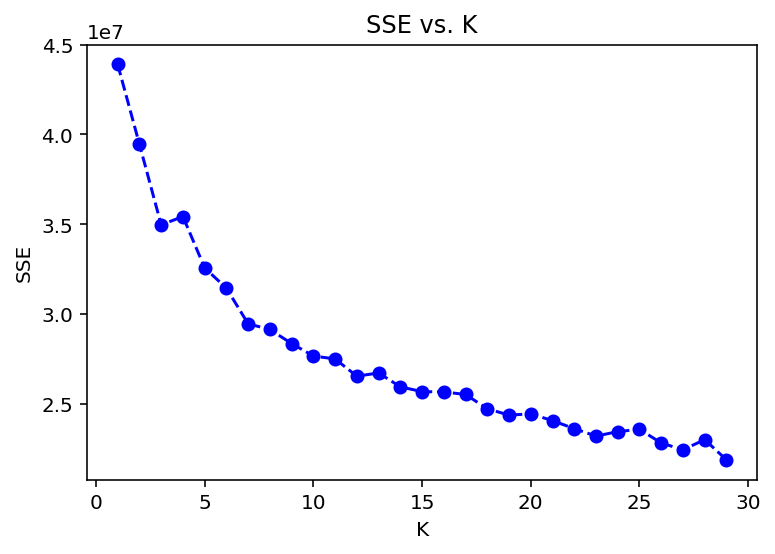

In [78]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 7)
kmodel_7 = kmeans.fit(pca_features_25)
predict_general = kmodel_7.predict(pca_features_25)

In [80]:
predict_general, len(predict_general)

(array([6, 0, 4, ..., 0, 6, 1], dtype=int32), 774743)

In [81]:
(unique, counts) = np.unique(predict_general, return_counts=True)
print(unique,counts)
general_dis = pd.concat([pd.Series(unique, name='Cluster'), pd.Series(counts, name = 'Count General')], axis=1) 

[0 1 2 3 4 5 6] [103402 108881  83686 110228 128831 136744 102971]


### Discussion 3.1: Apply Clustering to General Population

Since `KMeans` take too much time, we perform `MiniBatchKMeans` clustering into the 25 features we create. Observing the distance to the centroid curve, we can see that the elbow point can be inferred as 7 and we can use 7 as the number of clusters on the transformed demographics data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [82]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers_clean = clean_data(customers)
customers_clean.head()

55493 rows have many missing data
Total rows in dataset is 136159


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
2                   4.0          2                  5              1   
3                   4.0          1                  5              1   
4                   3.0          1                  3              1   
5                   3.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
2                 5               1                      4                 4   
3                 5               2                      1                 2   
4                 4               4                      5                 2   
5                 5               1                      2                 3   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0                 1         1.0     ...              1.0       5.0       5.0   
2                 1         2.0     ...              3.0       3.0       2.0   
3                 0         2.0     ...              1.0       3.0       4.0   
4                 0         3.0     ...              2.0       3.0       3.0   
5                 1         3.0     ...              1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADES  MOVEMENTS  WEALTH  LIFE_STAGE  
0     1.0          2.0       1.0      2.0        0.0     1.0         3.0  
2     3.0          5.0       3.0      2.0        0.0     3.0         4.0  
3     1.0          3.0       1.0      1.0        1.0     2.0         4.0  
4     3.0          5.0       1.0      4.0        1.0     4.0         1.0  
5     3.0          7.0       5.0      2.0        0.0     3.0         4.0  

[5 rows x 68 columns]

In [83]:
# Compare columns from general data to customers data
list(set(azdias.columns) - set(customers_clean))

[]

In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#copy df
customers_copy = customers_clean.copy()

#impute data for nan
imputer = Imputer(strategy='mean', axis=0)
customers_copy = imputer.fit_transform(customers_copy)
customers_copy = pd.DataFrame(customers_copy, columns = columns)


#standerdize dataframe 
customers_copy = scaler.transform(customers_copy)
customers_copy = pd.DataFrame(customers_copy, columns= columns)
customers_copy.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.181742   0.958422           1.415239      -1.151076   
1              1.181742   2.960226           1.415239      -1.151076   
2              1.181742   0.958422           1.415239      -1.151076   
3              0.199492   0.958422          -0.036773      -1.151076   
4              0.199492   0.958422           1.415239      -1.151076   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.133590       -1.247929              -0.454293         -0.818216   
1          1.133590       -1.247929               0.981043          0.612067   
2          1.133590       -0.568811              -1.171961         -0.818216   
3          0.407498        0.789423               1.698711         -0.818216   
4          1.133590       -1.247929              -0.454293         -0.103075   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0          1.882757   -1.629936     ...        -0.650851  1.432085  1.464805   
1          1.882757   -0.276069     ...         0.725656 -0.632597 -1.247491   
2         -0.531136   -0.276069     ...        -0.650851 -0.632597  0.560706   
3         -0.531136    1.077799     ...         0.037403 -0.632597 -0.343393   
4          1.882757    1.077799     ...        -0.650851  1.432085  1.464805   

     ARBEIT  ORTSGR_KLS9  RELAT_AB   DECADES  MOVEMENTS    WEALTH  LIFE_STAGE  
0 -2.186657    -1.439900 -1.533713 -1.621012  -1.873696 -1.555604    0.087197  
1 -0.175332    -0.133626 -0.058527 -1.621012  -1.873696 -0.187928    0.760743  
2 -2.186657    -1.004475 -1.533713 -2.318322   0.551870 -0.871766    0.760743  
3 -0.175332    -0.133626 -1.533713 -0.226391   0.551870  0.495910   -1.259894  
4 -0.175332     0.737224  1.416660 -1.621012  -1.873696 -0.187928    0.760743  

[5 rows x 68 columns]

In [85]:
#Use our pca model with 25 components to fit general data
pca_customers = pca_model_25.transform(customers_copy)

#Use Kmeans model with 7 clusters to predict
predict_customers = kmodel_7.predict(pca_customers)

In [86]:
pca_customers

array([[-5.67260684,  1.65655454,  3.6092362 , ...,  0.93319428,
         1.09561504, -0.12725199],
       [-0.62123304,  5.39972616, -1.30639173, ..., -0.94365825,
         0.82212956,  1.10188867],
       [-4.45387617,  0.89297178,  1.97495161, ...,  0.07393843,
        -0.25315032,  0.60555646],
       ..., 
       [-4.55010329,  3.2744463 ,  1.7870681 , ...,  0.15681197,
         0.09818856, -0.39388258],
       [-1.12927746,  2.96927984, -2.71398715, ..., -0.86475528,
         0.48973116,  0.7501593 ],
       [-4.39679981, -2.25818029,  1.63846202, ...,  1.11679821,
         0.08826725,  0.48413546]])

In [87]:
predict_customers

array([5, 3, 5, ..., 5, 4, 5], dtype=int32)

In [88]:
pca_customers_df = pd.DataFrame(pca_customers, columns=np.arange(1, 26))
pca_customers_df.head()

1         2         3         4         5         6         7   \
0 -5.672607  1.656555  3.609236  1.009800 -3.141264  1.551656  1.289583   
1 -0.621233  5.399726 -1.306392  2.127451 -0.813784 -1.872570 -0.500173   
2 -4.453876  0.892972  1.974952 -2.594713 -0.066873  0.665071  0.898202   
3  1.060623 -0.885695  0.474672  0.672430  2.469453  2.080478 -2.406544   
4 -2.046046  1.871204  2.231774  2.744016 -2.689627  0.847951 -1.310067   

         8         9         10    ...           16        17        18  \
0 -1.624040 -0.479066  0.307359    ...     1.215759 -0.109348 -0.254699   
1  0.971644 -0.918653  1.074578    ...     2.196413 -0.076532  0.184708   
2  0.336311  0.641792  1.474192    ...     0.738300 -0.058727  0.983571   
3  0.082757 -0.823540  3.160574    ...     0.653315 -0.118989 -0.274782   
4  0.799691 -1.496522 -0.057595    ...     1.131135 -0.052911  1.479930   

         19        20        21        22        23        24        25  
0 -0.617042 -0.156191 -0.308996 -1.673545  0.933194  1.095615 -0.127252  
1 -0.092056 -1.925688 -1.744336 -0.370244 -0.943658  0.822130  1.101889  
2  0.793121 -0.157071 -0.285158  0.748512  0.073938 -0.253150  0.605556  
3 -0.985227 -0.947508 -0.343248 -0.598365 -0.774976  0.197831  1.985392  
4 -0.018674 -1.072197 -1.417297  0.526759 -0.000662 -0.608091  1.577924  

[5 rows x 25 columns]

In [72]:
(unique, counts) = np.unique(predict_customers, return_counts=True)
print(unique,counts)

customer_dis = pd.concat([pd.Series(unique, name='Cluster'), pd.Series(counts, name = 'Count Customer')], axis=1) 

# customer_dis['Dist General'] = customer_dis['Count General']/customer_dis['Count General'].sum()
customer_dis

[0 1 2 3 4 5 6] [ 2893 17229  2450 15201 26255 70424  1707]


Cluster  Count Customer
0        0            2893
1        1           17229
2        2            2450
3        3           15201
4        4           26255
5        5           70424
6        6            1707

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
dist = pd.merge(general_dis, customer_dis, on='Cluster')

#assign rows with lots of missing value as Cluster -1
missing_row = {'Cluster': -1, 'Count General':len(many_missing_row), 'Count Customer':55493}
#add numbers of missing rows in the distribution 
dist = dist.append(missing_row, ignore_index = True)

dist['Dist General'] = dist['Count General']/dist['Count General'].sum()
dist['Dist Customer'] = dist['Count Customer']/dist['Count Customer'].sum()
dist.index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5','Cluster 6','Cluster -1']
# dist.index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster -1']
dist

Cluster  Count General  Count Customer  Dist General  \
Cluster 0         0         103402            2893      0.116023   
Cluster 1         1         108881           17229      0.122171   
Cluster 2         2          83686            2450      0.093900   
Cluster 3         3         110228           15201      0.123682   
Cluster 4         4         128831           26255      0.144556   
Cluster 5         5         136744           70424      0.153434   
Cluster 6         6         102971            1707      0.115539   
Cluster -1       -1         116478           55493      0.130695   

            Dist Customer  
Cluster 0        0.015095  
Cluster 1        0.089897  
Cluster 2        0.012784  
Cluster 3        0.079316  
Cluster 4        0.136993  
Cluster 5        0.367458  
Cluster 6        0.008907  
Cluster -1       0.289551

(array([ 0.175,  1.175,  2.175,  3.175,  4.175,  5.175,  6.175,  7.175]),
 <a list of 8 Text xticklabel objects>)

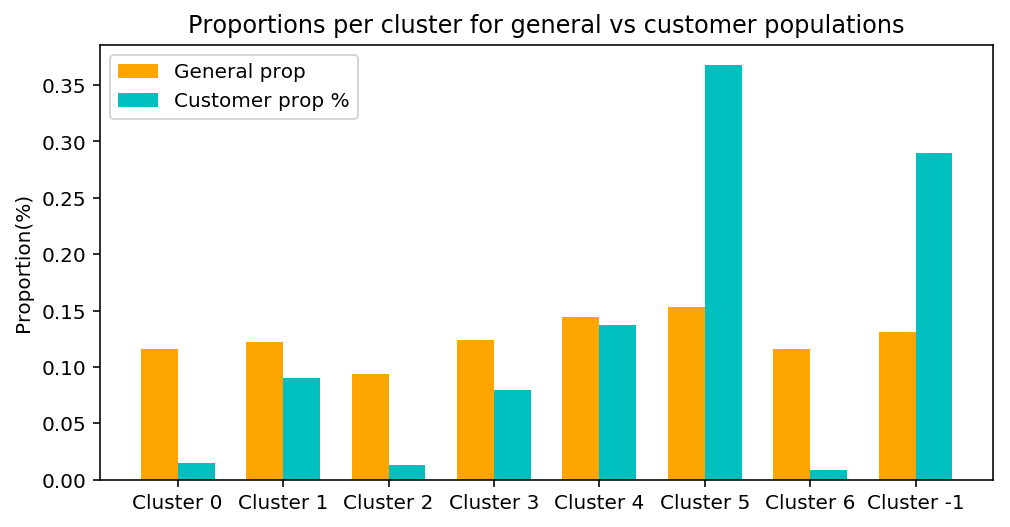

In [75]:
fig, ax = plt.subplots(figsize=(8,4))
bar_width = 0.35
index = np.arange(8)


gen = plt.bar(index, dist['Dist General'], bar_width, 
                 color='orange',
                 label='General Population')
 
cust = plt.bar(index + bar_width, dist['Dist Customer'], bar_width,
                 color='c',
                 label='Customer Data')

ax.set_ylabel('Proportion(%)')
ax.set_title('Proportions per cluster for general vs customer populations')
plt.legend(('General prop', 'Customer prop %'),fontsize=10)
plt.xticks(index + bar_width/2, dist.index)
plt.xticks(rotation = 360)


In [78]:
dist['Dist Customer'] - dist['Dist General']

Cluster 0    -0.100928
Cluster 1    -0.032273
Cluster 2    -0.081117
Cluster 3    -0.044366
Cluster 4    -0.007563
Cluster 5     0.214023
Cluster 6    -0.106632
Cluster -1    0.158856
dtype: float64

Cluster 5 and missing data are overrepresented, while Cluster 0 and Cluster 6 are underrepresented.

In [108]:
# What kinds of people are part of a cluster that is overrepresented or underrepresented in the
# customer data compared to the general population?

# scaler.inverse_transform(pca_model_25.inverse_transform(pca_customers[np.where(predict_customers ==5)])).round(1)

# Over represented group: Let's look at cluster 5
over_represent = scaler.inverse_transform(pca_model_25.inverse_transform(kmodel_7.cluster_centers_[5]))
over_represent_features = pd.Series(over_represent, index = azdias_copy.columns)
over_represent_features.sort_values(ascending = False).head()
over_represent_features.sort_values(ascending = False).tail(5)

ANREDE_KZ       0.086157
KBA05_ANTG4     0.031118
ANZ_HH_TITEL    0.009905
SOHO_KZ         0.009339
ANZ_TITEL       0.006039
dtype: float64

In [109]:
# Under represented group: Let's look at cluster 6
under_represent = scaler.inverse_transform(pca_model_25.inverse_transform(kmodel_7.cluster_centers_[6]))
under_represent_features = pd.Series(under_represent, index = azdias_copy.columns)
under_represent_features.sort_values(ascending = False).head()


KBA05_ANTG1         0.258451
ANZ_HH_TITEL        0.078939
GREEN_AVANTGARDE    0.059244
SOHO_KZ             0.007872
ANZ_TITEL           0.002047
dtype: float64

In [110]:
# Under represented group: Let's look at cluster 0
under_represent = scaler.inverse_transform(pca_model_25.inverse_transform(kmodel_7.cluster_centers_[0]))
under_represent_features = pd.Series(under_represent, index = azdias_copy.columns)
under_represent_features.sort_values(ascending = False).head()
under_represent_features.sort_values(ascending = False).tail()

GREEN_AVANTGARDE    0.169729
KBA05_ANTG4         0.098680
ANZ_HH_TITEL        0.010072
SOHO_KZ             0.008587
ANZ_TITEL           0.002797
dtype: float64

In [102]:
#add cluster number back to pca data 
pca_customers_df['cluster'] = predict_customers
pca_customers_df.head()

1         2         3         4         5         6         7  \
0 -5.672607  1.656555  3.609236  1.009800 -3.141264  1.551656  1.289583   
1 -0.621233  5.399726 -1.306392  2.127451 -0.813784 -1.872570 -0.500173   
2 -4.453876  0.892972  1.974952 -2.594713 -0.066873  0.665071  0.898202   
3  1.060623 -0.885695  0.474672  0.672430  2.469453  2.080478 -2.406544   
4 -2.046046  1.871204  2.231774  2.744016 -2.689627  0.847951 -1.310067   

          8         9        10   ...           17        18        19  \
0 -1.624040 -0.479066  0.307359   ...    -0.109348 -0.254699 -0.617042   
1  0.971644 -0.918653  1.074578   ...    -0.076532  0.184708 -0.092056   
2  0.336311  0.641792  1.474192   ...    -0.058727  0.983571  0.793121   
3  0.082757 -0.823540  3.160574   ...    -0.118989 -0.274782 -0.985227   
4  0.799691 -1.496522 -0.057595   ...    -0.052911  1.479930 -0.018674   

         20        21        22        23        24        25  cluster  
0 -0.156191 -0.308996 -1.673545  0.933194  1.095615 -0.127252        5  
1 -1.925688 -1.744336 -0.370244 -0.943658  0.822130  1.101889        3  
2 -0.157071 -0.285158  0.748512  0.073938 -0.253150  0.605556        5  
3 -0.947508 -0.343248 -0.598365 -0.774976  0.197831  1.985392        1  
4 -1.072197 -1.417297  0.526759 -0.000662 -0.608091  1.577924        5  

[5 rows x 26 columns]

### Using pairplots to investigate components in each variables 

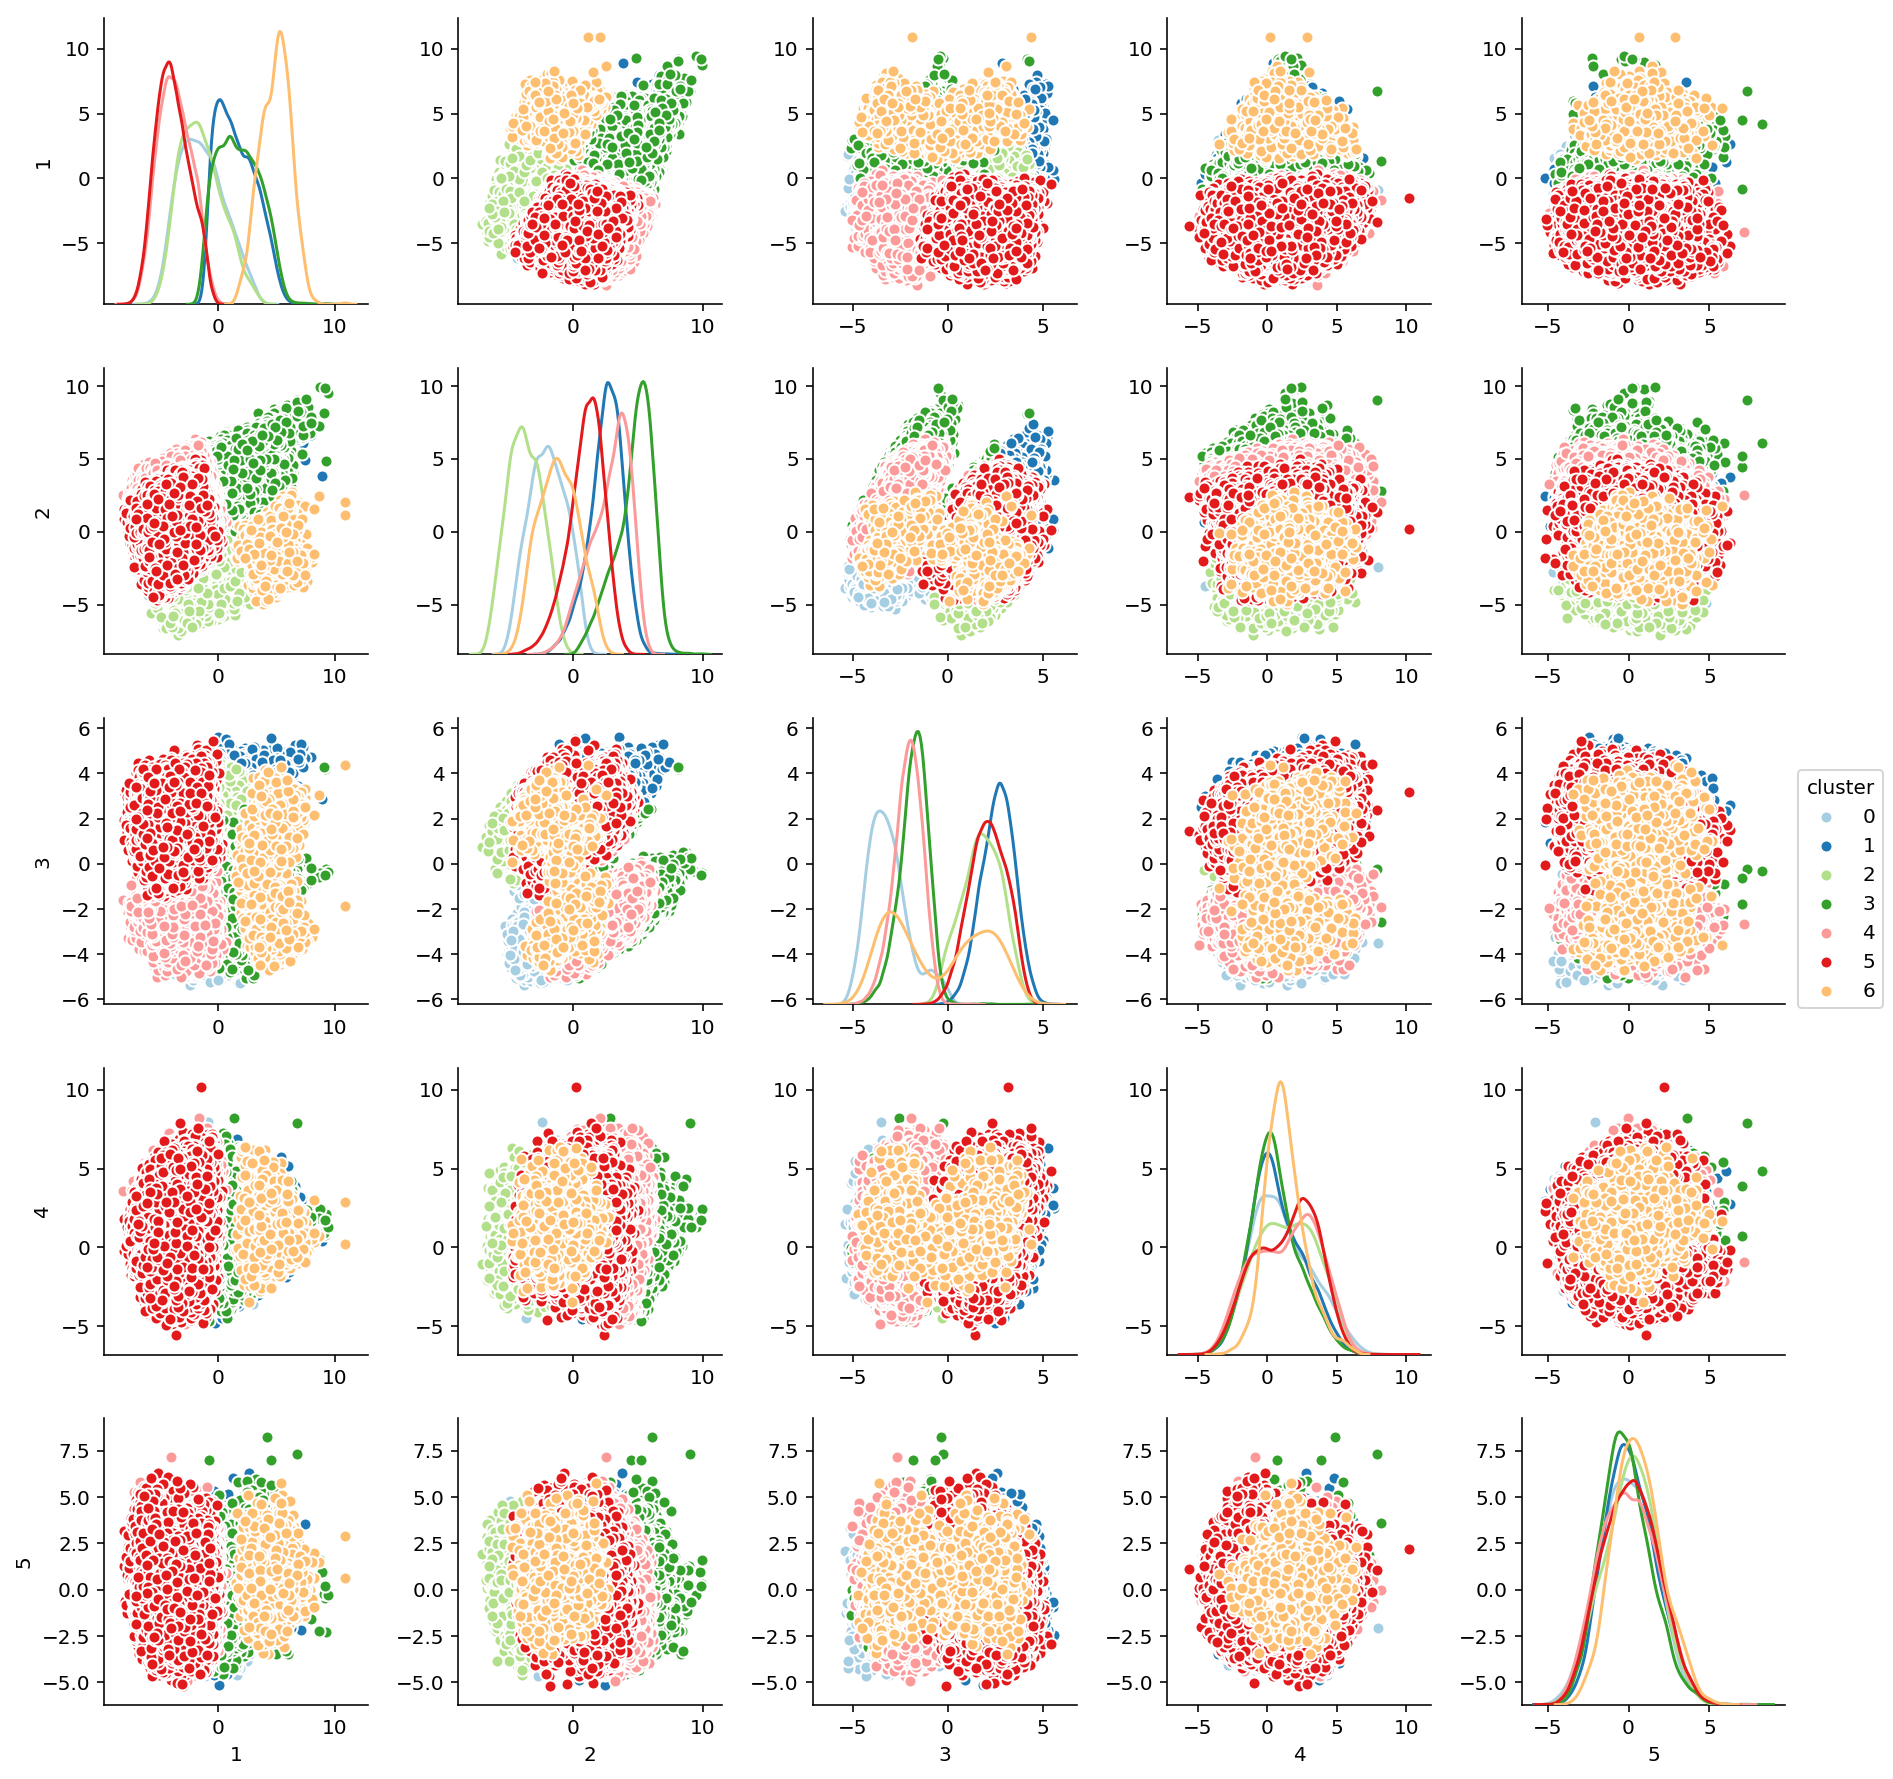

In [80]:
sns.pairplot(pca_customers_df,
                 vars = np.arange(1, 6), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

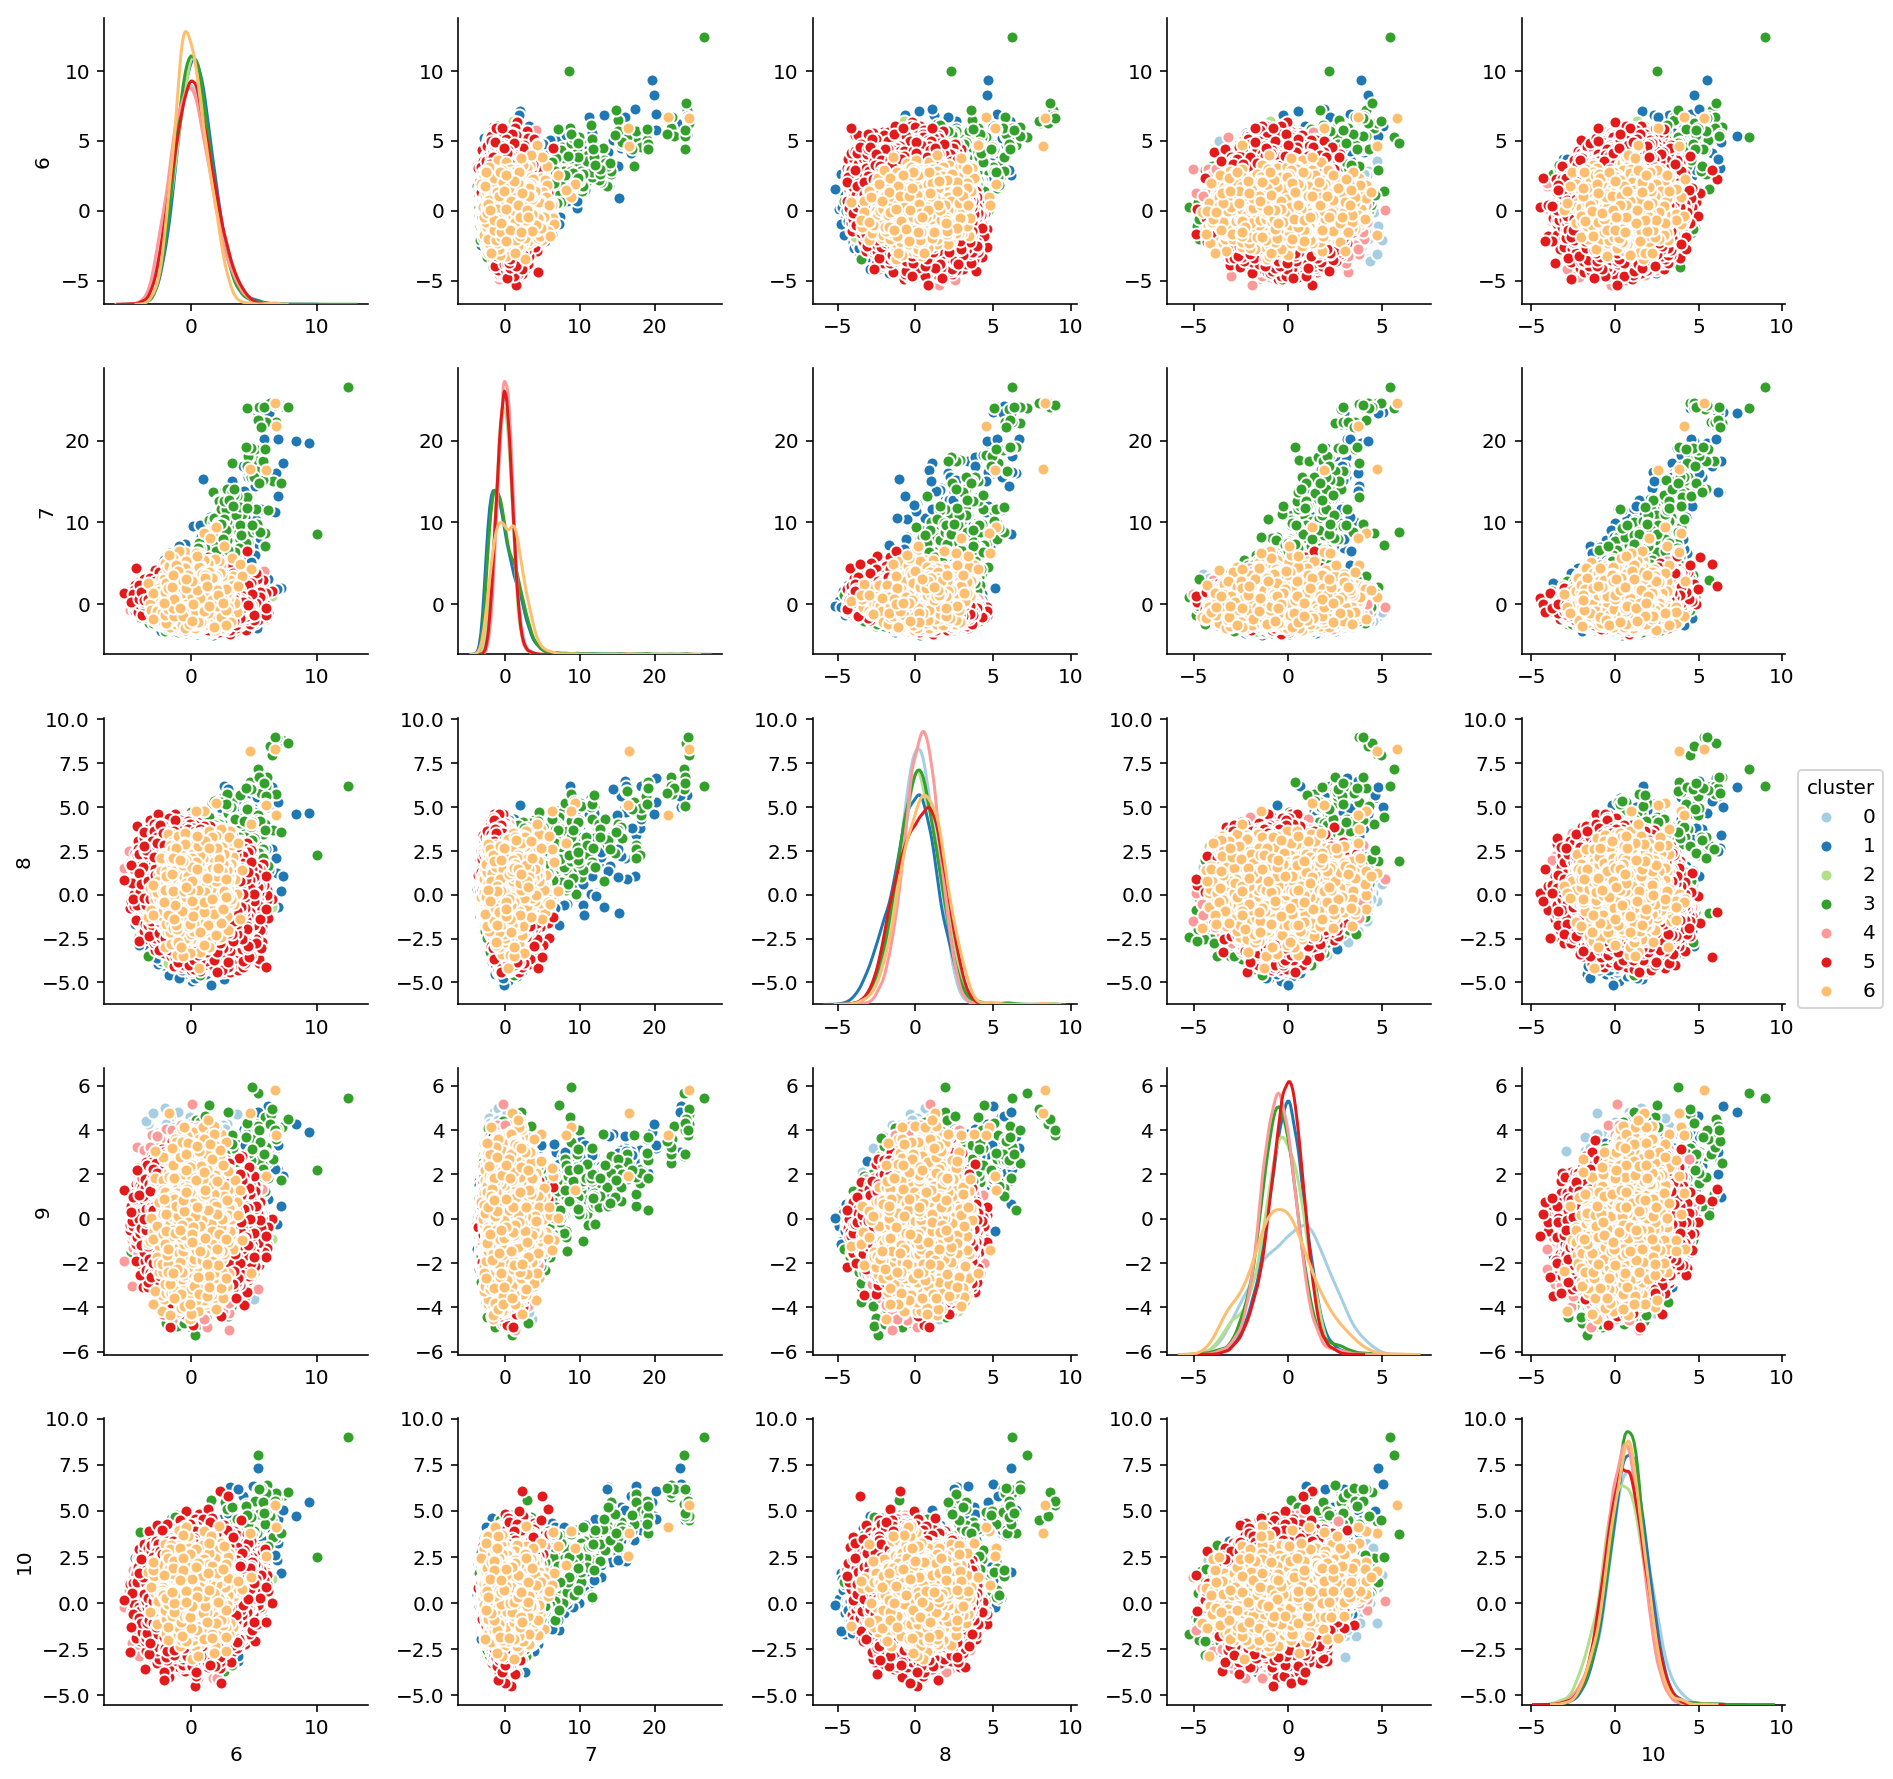

In [85]:
sns.pairplot(pca_customers_df,
                 vars = np.arange(6, 11), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

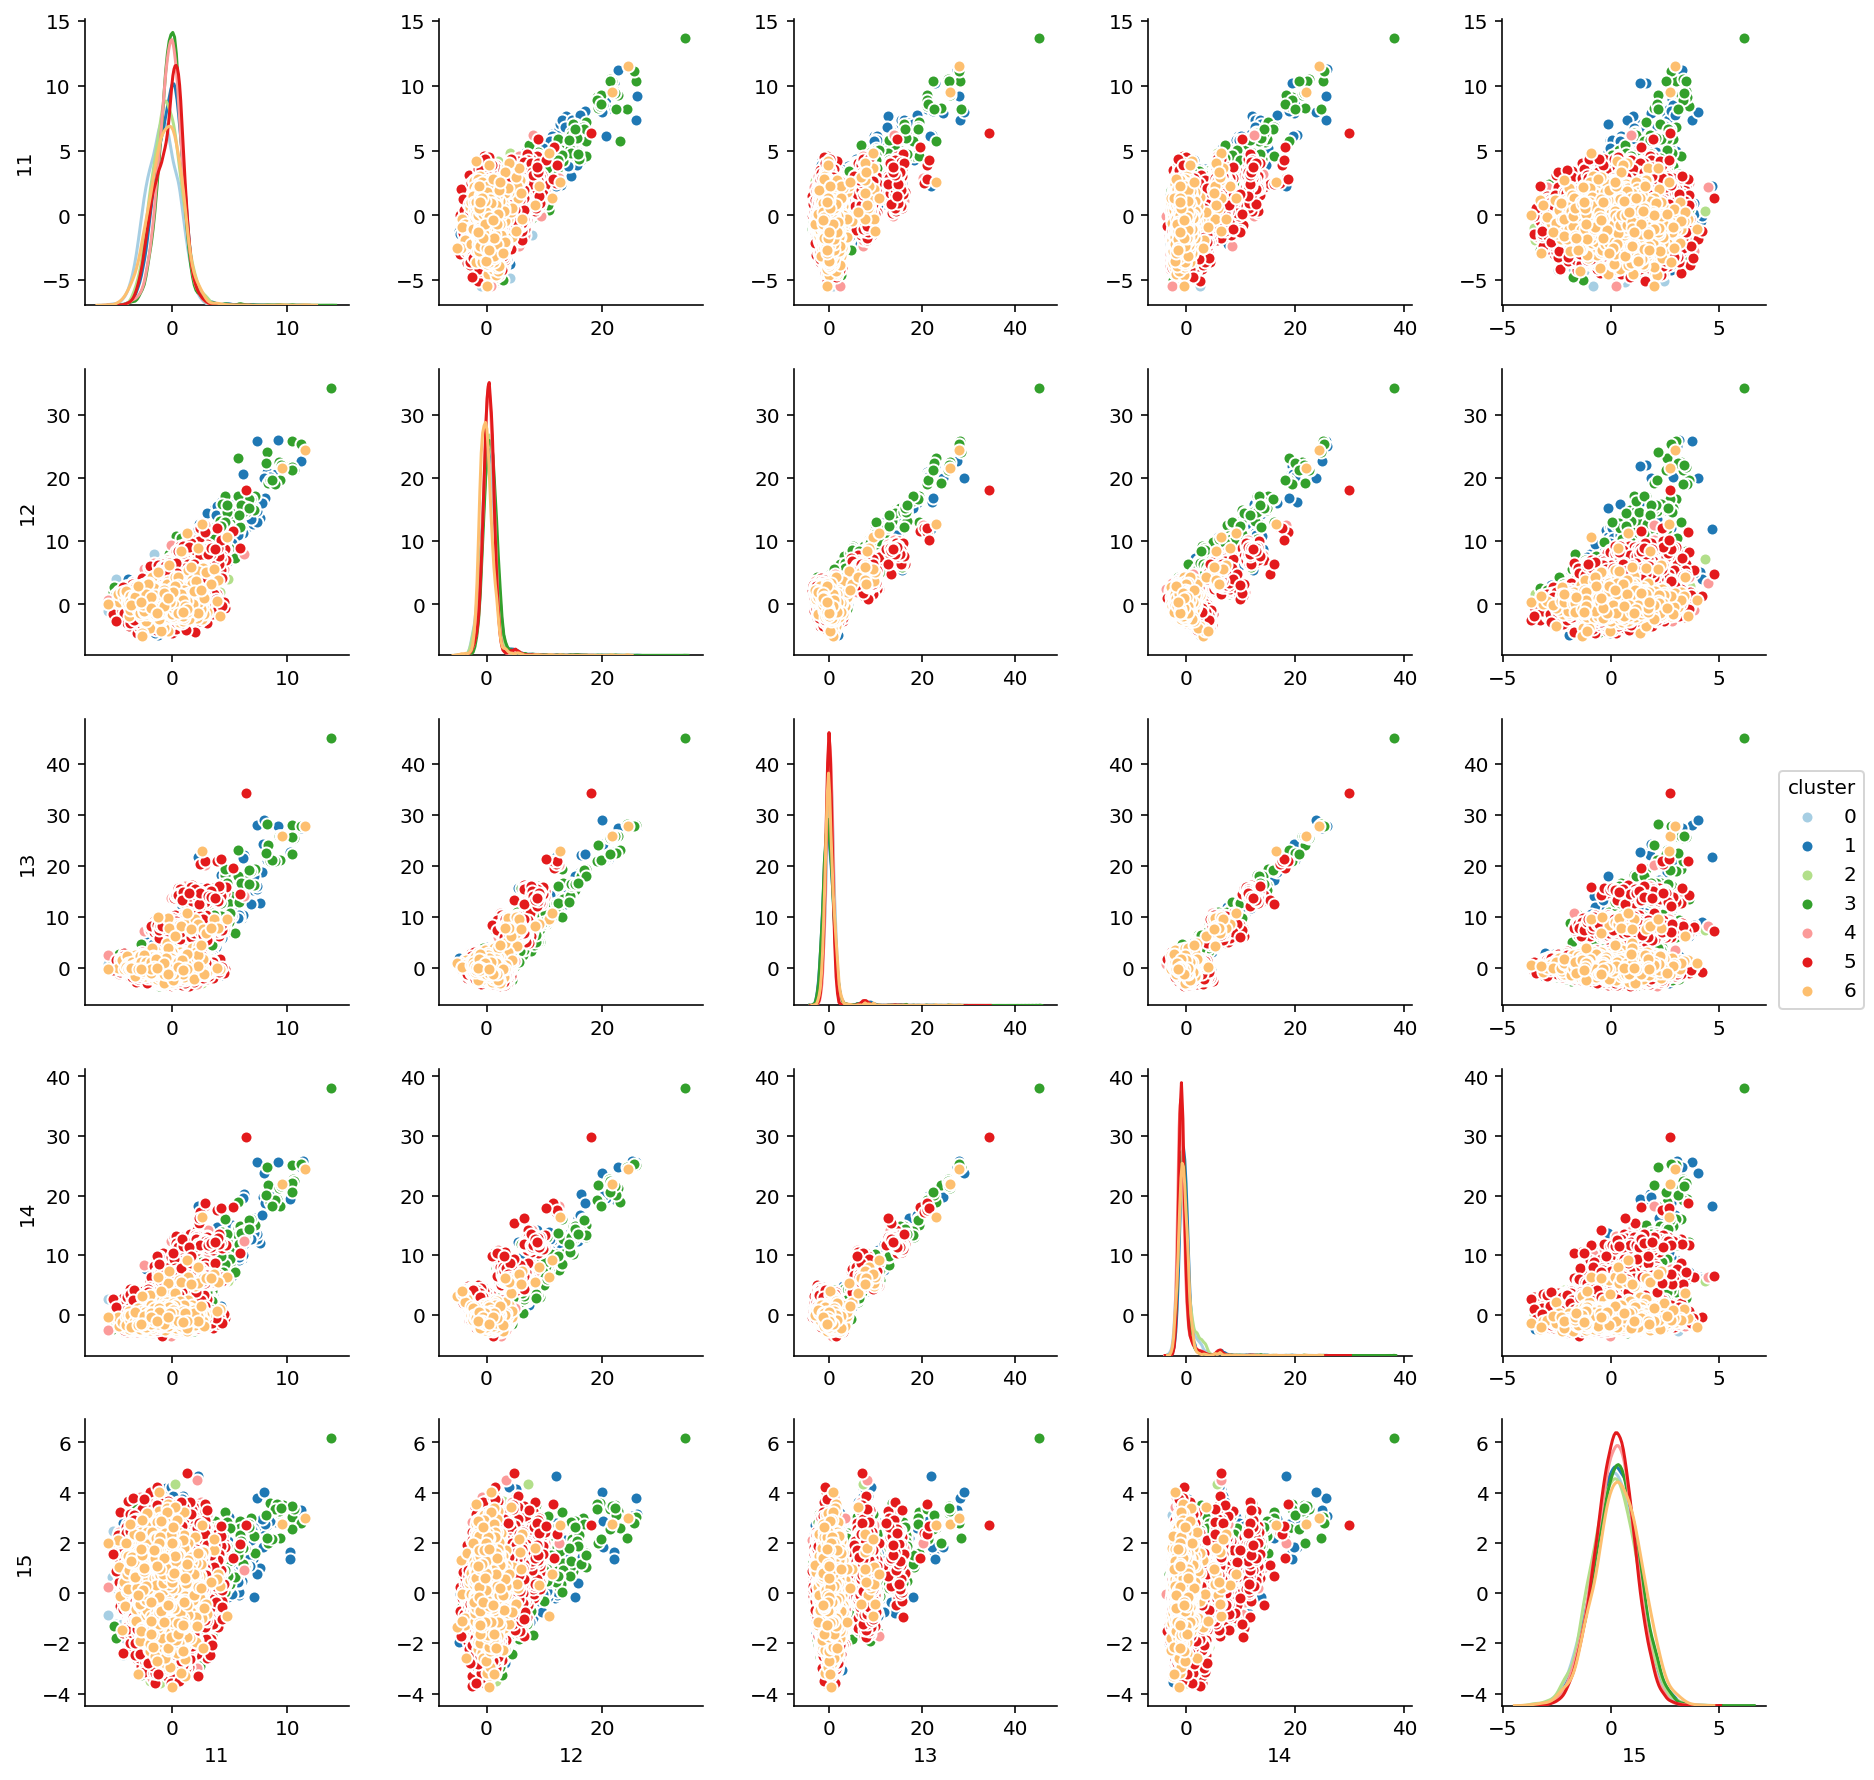

In [86]:
sns.pairplot(pca_customers_df,
                 vars = np.arange(11, 16), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

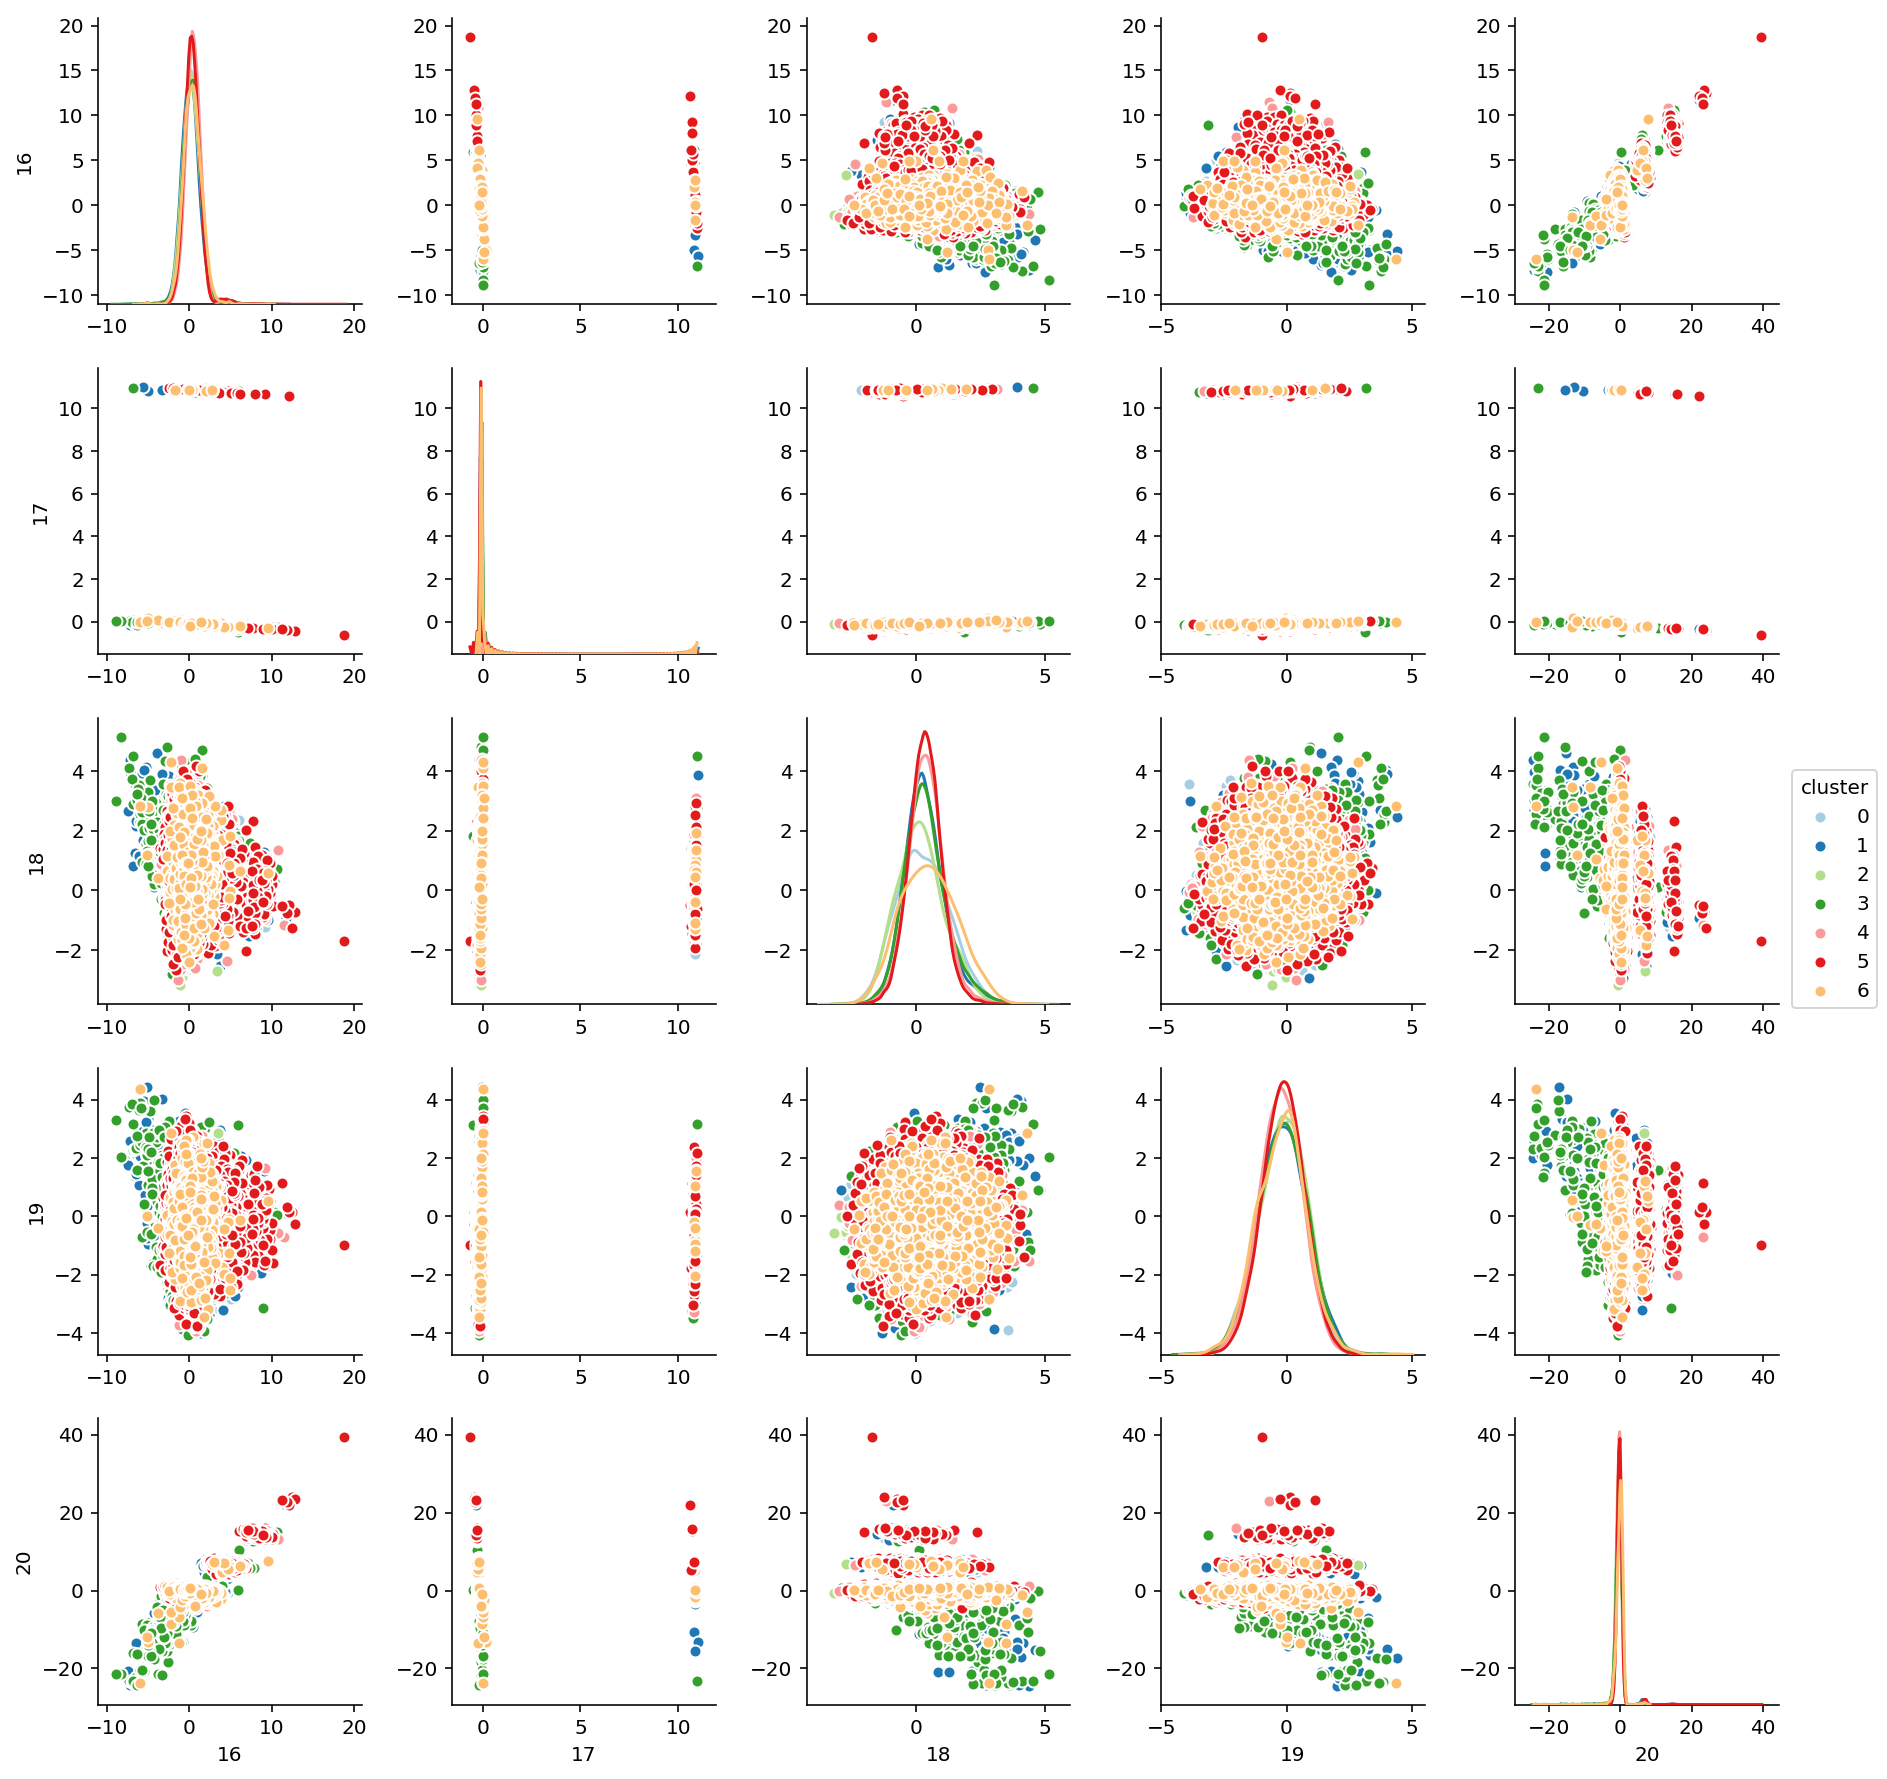

In [87]:
sns.pairplot(pca_customers_df,
                 vars = np.arange(16, 21), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

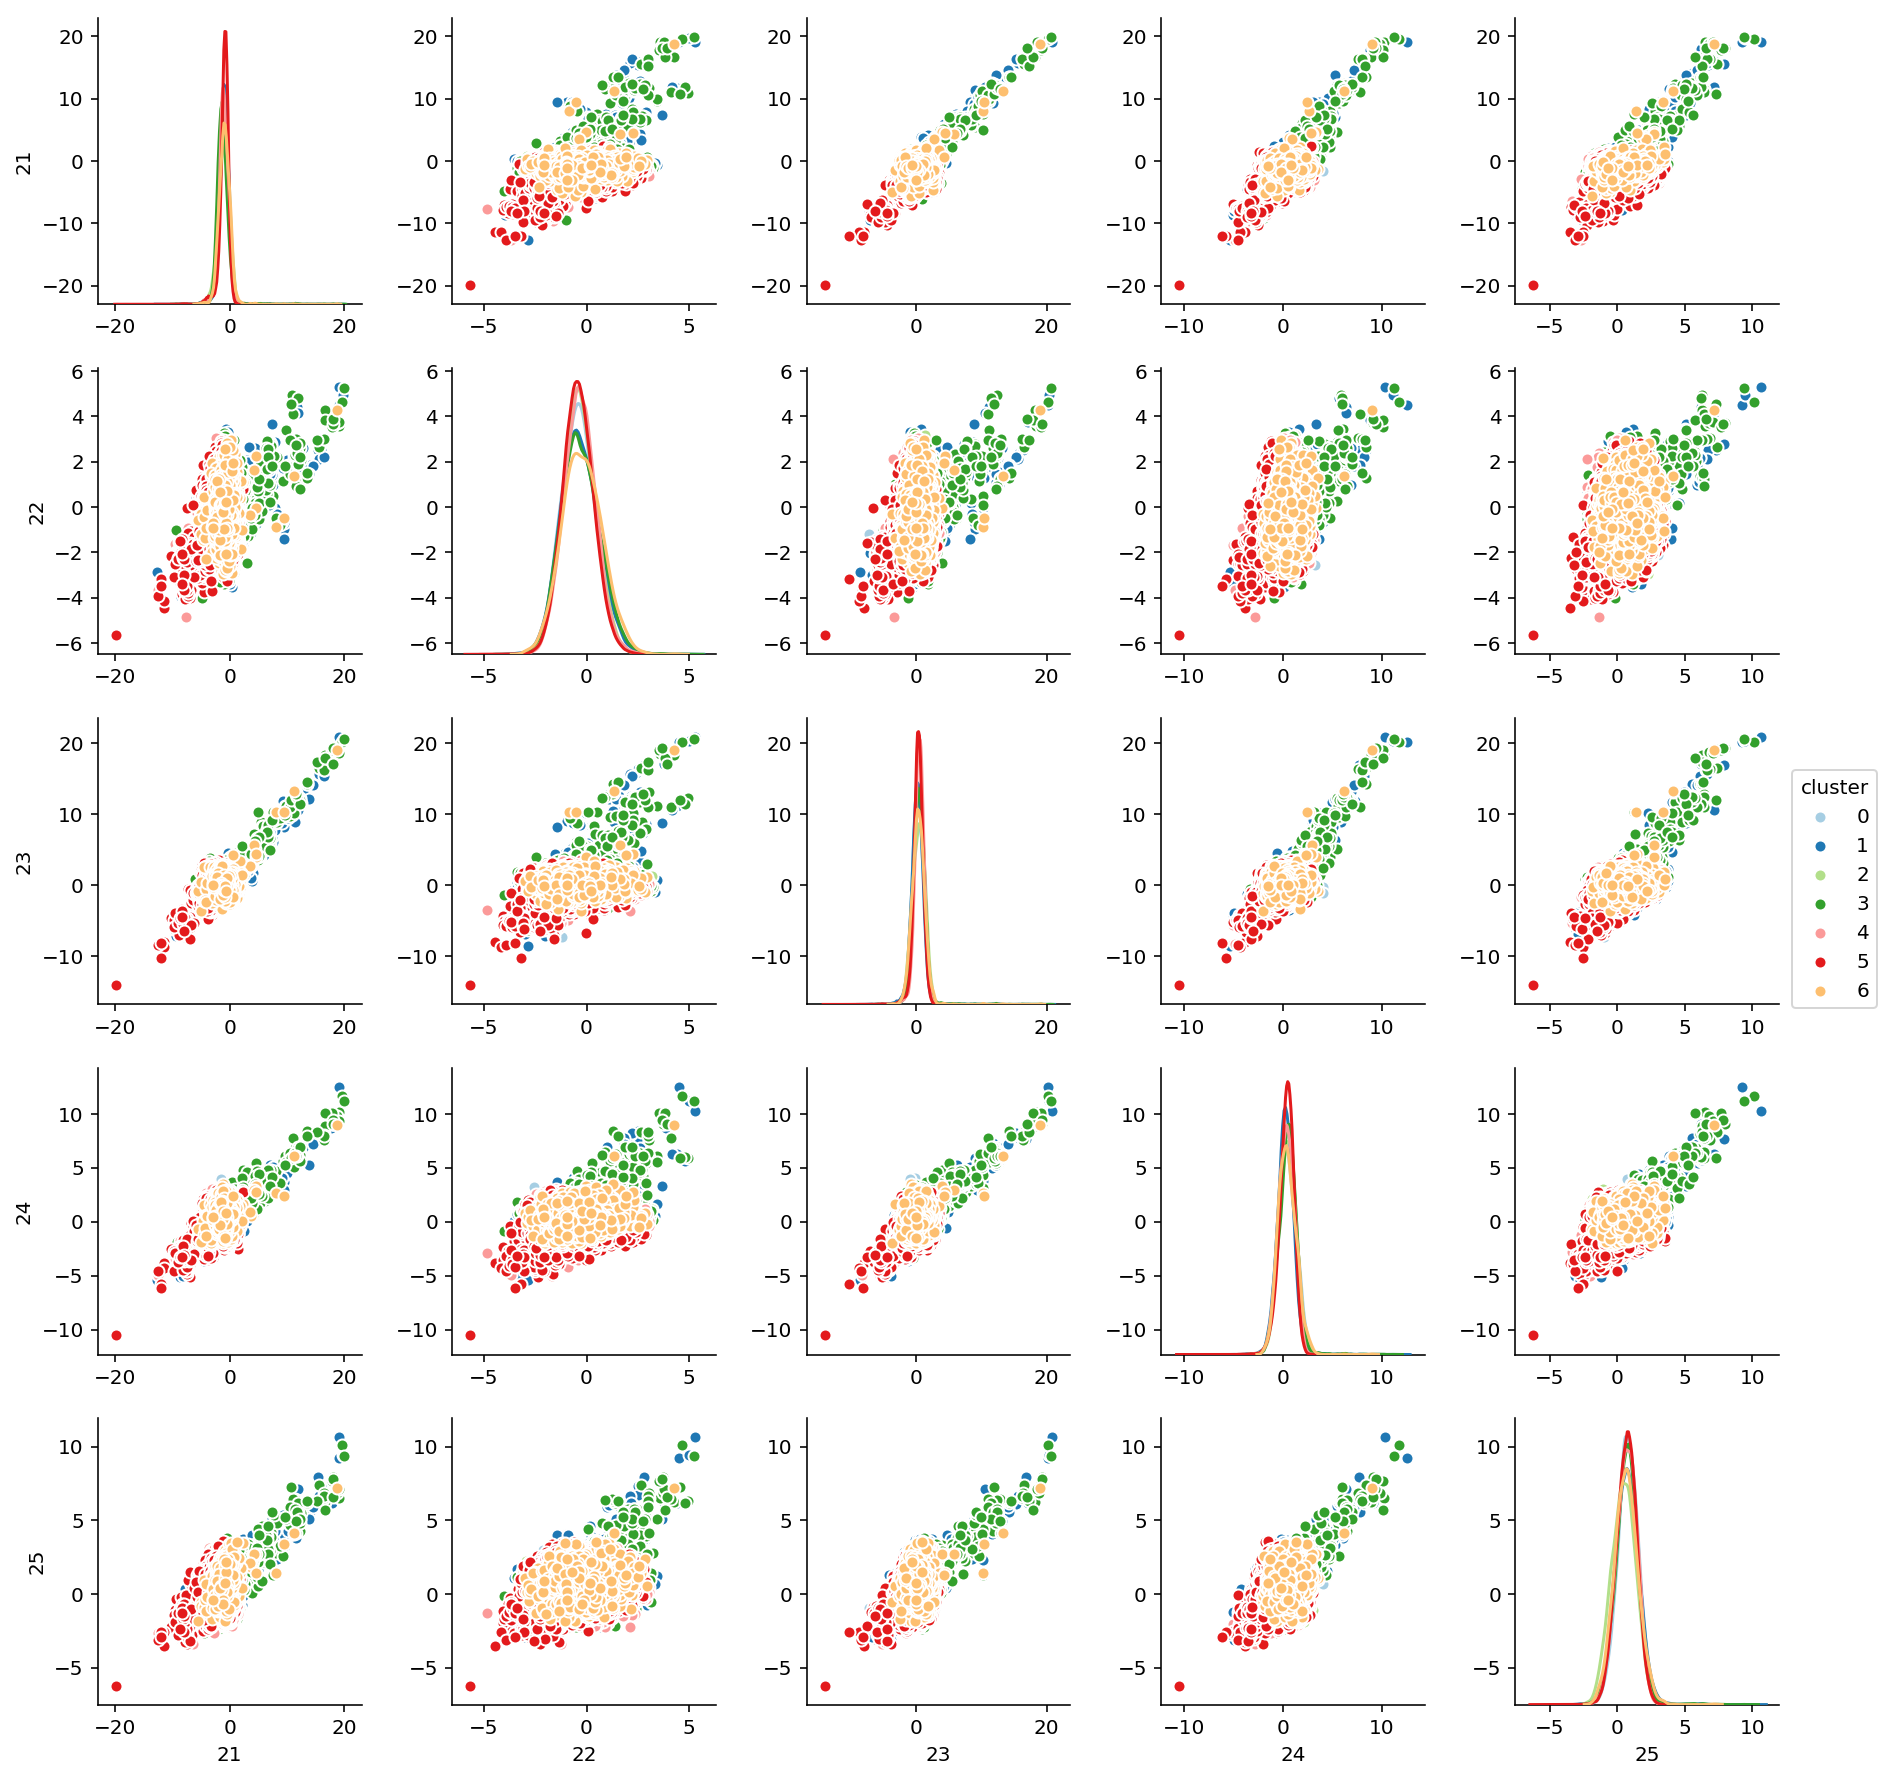

In [88]:
sns.pairplot(pca_customers_df,
                 vars = np.arange(21, 26), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

In [98]:
def map_kmeans_weights_to_feats(kmeans, df, nth_cluster):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights'''

    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns= df.keys())
    centroid = weights.iloc[nth_cluster, :]
    cent_pos = centroid[centroid > 0].sort_values(ascending=False)
    cent_neg = centroid[centroid < 0].sort_values(ascending=True)

    return cent_pos, cent_neg

In [111]:
# Over represented group: Let's look at cluster 5
positive, negative = map_kmeans_weights_to_feats(kmodel_7, pca_customers_df.iloc[:, :-1], 5)

from IPython.core.display import HTML

def create_bar_table(comp_pos, comp_neg):
    '''Create and display a conditionally styled pandas dataframe
    for the interpertation of the positive and negative weights
    of PCA and centroid distances for KMeans'''
    
    head = """
    <table>
    """
    row = ""
    for serie in [comp_pos[:15],comp_neg[:15]]:
        s = serie.copy()
        s.name=''
        row += "<td>{}</td>".format(s.to_frame().style.bar(
                                                           align='mid',
                                                           color=['#d65f5f', '#5fba7d'],
                                                           width=100).render()
                                   ) 
    row += '</tr>'
    head += row

    head+= """
    </table>"""

    display(HTML(head))

create_bar_table(positive, negative)

Citation: for map_kmeans_weights_to_feats and create_bar_table, I follow the code [here](https://jkarakas.github.io/Customer-Demographics-Segmentation-/Customer_Segmentation.html#Summary)

### Discussion 3.3: Compare Customer Data to Demographics Data

We can see that we have a large proportion of missing data in customer data than general demographic data, which might due to limitations during the data collection process. Comparing the proportion of clusters in the two data, we see that Cluster 5 is overrepresented in the customer data, while Cluster 0 and Cluster 6 are underrepresented. 

Significant variables in Cluster 5 include MIN_GEBAEUDEJAHR, KBA13_ANZAHL_PKW, LP_LEBENSPHASE_FEIN, which represent First-year building, numbers of cars, and life stage of a person. It is so weird because they are similar to the variables we find in Cluster 0 and 6. And I don't know how to interpret these three variables. 


Therefore, I try to use a pair plot and interpret the cluster through components. I learn `map_kmeans_weights_to_feats` to produce important components for Cluster 5. It shows that Component 3 is the most positive and Component 1 is the most negative. This indicates they are males that are less dreamful, less social, less family-oriented, and they are conservative return shopping type. They have a smaller family capacity with decent financial affluence.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

## References

1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. https://online.stat.psu.edu/stat505/lesson/11/11.4
3. https://mubaris.com/posts/kmeans-clustering/
3. https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb

        